<a href="https://colab.research.google.com/github/preethamcharan/x23183683_Thesis/blob/main/Thesis_Bot_IoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# this module provides functions for interacting with the operating system
import os
import pickle
import sys

# it's used for mathematical operations on large, multi-dimensional arrays and matrices
import numpy as np

# Pandas used for data manipulation and analysis
import pandas as pd

# data visualization library for 2D and 3D plots, built on numpy
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn is based on matplotlib; used for plotting statistical graphics
import seaborn as sns

# plotting
import plotly.express as px

# sklearn helpful ML libraries including clasifiers
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE
import time

# to suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Define paths to your data files in Google Drive
train_path = '/content/drive/My Drive/Bot_IoT/UNSW_2018_IoT_Botnet_Final_10_best_Training.csv'
test_path = '/content/drive/My Drive/Bot_IoT/UNSW_2018_IoT_Botnet_Final_10_best_Testing.csv'

# Load the datasets
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Check the shape of the loaded data
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)
train_data.head(), test_data.head()

Train Data Shape: (2934817, 19)
Test Data Shape: (733705, 19)


(   pkSeqID proto            saddr  sport          daddr dport     seq  \
 0  3142762   udp  192.168.100.150   6551  192.168.100.3    80  251984   
 1  2432264   tcp  192.168.100.150   5532  192.168.100.3    80  256724   
 2  1976315   tcp  192.168.100.147  27165  192.168.100.3    80   62921   
 3  1240757   udp  192.168.100.150  48719  192.168.100.3    80   99168   
 4  3257991   udp  192.168.100.147  22461  192.168.100.3    80  105063   
 
      stddev  N_IN_Conn_P_SrcIP       min  state_number      mean  \
 0  1.900363                100  0.000000             4  2.687519   
 1  0.078003                 38  3.856930             3  3.934927   
 2  0.268666                100  2.974100             3  3.341429   
 3  1.823185                 63  0.000000             4  3.222832   
 4  0.822418                100  2.979995             4  3.983222   
 
    N_IN_Conn_P_DstIP  drate     srate       max  attack category subcategory  
 0                100    0.0  0.494549  4.031619       1  

In [ ]:
#ARP packets were excluded because they are used to convert an IP address to a MAC address and irrelevant to the proposed attacks in the dataset
train_data = train_data[train_data.proto!="arp"]
test_data = test_data[test_data.proto!="arp"]

#dropping unused columns
train_data.drop(['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport',"attack","category"],axis=1,inplace=True)
test_data.drop(['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport',"attack","category"],axis=1,inplace=True)
full_data = pd.concat([train_data,test_data],axis=0)

In [ ]:
# Select samples of "Data_Exfiltration" from train_data
data_exf = train_data.loc[train_data.subcategory == "Data_Exfiltration"].sample(n=2, random_state=42)

# Append the sampled data to test_data using pd.concat
test_data = pd.concat([test_data, data_exf])

# Drop the selected samples from train_data
train_data = train_data.drop(data_exf.index)

In [ ]:
# Place the class in the begining of the dataframe
class_train = train_data['subcategory']
train_data.drop(['subcategory'], axis=1, inplace=True)
train_data.insert(0, 'subcategory', class_train)

class_test = test_data['subcategory']
test_data.drop(['subcategory'], axis=1, inplace=True)
test_data.insert(0, 'subcategory', class_test)

class_full = full_data['subcategory']
full_data.drop(['subcategory'], axis=1, inplace=True)
full_data.insert(0, 'subcategory', class_full)

In [ ]:
test_data.subcategory.value_counts()

,count
subcategory,
UDP,396568
TCP,318332
Service_Scan,14530
OS_Fingerprint,3615
HTTP,502
Normal,98
Keylogging,13
Data_Exfiltration,2


In [ ]:
train_data.subcategory.value_counts()

,count
subcategory,
UDP,1584622
TCP,1274811
Service_Scan,58592
OS_Fingerprint,14267
HTTP,1965
Normal,332
Keylogging,57
Data_Exfiltration,3


In [ ]:
d = full_data.subcategory.value_counts()
fig = px.bar(d, x=d.index, y=d.values,title = 'Class distribution between attack subcategories on full data',labels = {'index':'Attack','y':'Volume'},color=d.values)
fig.update_layout(title_x=0.5,width=1000, height=400)
fig.show()

In [ ]:
percent_missing = train_data.isnull().sum() * 100 / len(train_data)
missing_values = pd.DataFrame({'% missing': percent_missing})
missing_values.sort_values(by ='% missing' , ascending=False)

,% missing
subcategory,0.0
seq,0.0
stddev,0.0
N_IN_Conn_P_SrcIP,0.0
min,0.0
state_number,0.0
mean,0.0
N_IN_Conn_P_DstIP,0.0
drate,0.0
srate,0.0


In [ ]:
pd.DataFrame({'Data Type': full_data.dtypes})

,Data Type
subcategory,object
seq,int64
stddev,float64
N_IN_Conn_P_SrcIP,int64
min,float64
state_number,int64
mean,float64
N_IN_Conn_P_DstIP,int64
drate,float64
srate,float64


In [ ]:
full_data['subcategory'] = np.where((full_data['subcategory'] == 'TCP') | (full_data['subcategory'] == 'UDP') | (full_data['subcategory'] == 'HTTP') , 'DoS&DDoS', full_data['subcategory'])

In [ ]:
d = full_data.subcategory.value_counts()
fig = px.bar(d, x=d.index, y=d.values,title = 'Class Label Distribution in Bot-IoT',labels = {'index':'Attack','y':'Volume'},color=d.values,text_auto='.2s')
fig.update_layout(title_x=0.5,width=1000, height=400)
fig.show()

In [ ]:
shuffled_df = full_data.sample(frac=1,random_state=4)

nondos_df = shuffled_df.loc[shuffled_df['subcategory'] != "DoS&DDoS"]

dos_df = shuffled_df.loc[shuffled_df['subcategory'] == "DoS&DDoS"].sample(n=73122,random_state=42)

normalized_full_df = pd.concat([nondos_df, dos_df])

#TRAIN after undersampling
d = normalized_full_df.subcategory.value_counts()
fig = px.bar(d, x=d.index, y=d.values,title = 'Class Label Distribution in Bot-IoT (undersampled)',labels = {'index':'Attack','y':'Volume'},color=d.values,text_auto='.2s')
fig.update_layout(title_x=0.5,width=1000, height=400)
fig.show()

In [ ]:
normalized_full_df.subcategory.value_counts()

,count
subcategory,
Service_Scan,73122
DoS&DDoS,73122
OS_Fingerprint,17882
Normal,430
Keylogging,70
Data_Exfiltration,5


In [ ]:
normalized_full_df.head()

,subcategory,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max
1285197,Service_Scan,20019,0.0,30,0.241459,6,0.241459,100,16.56596,20.707449,0.241459
700970,Service_Scan,19119,0.0,42,0.000000,5,0.000000,10,0.00000,0.000000,0.000000
506761,OS_Fingerprint,7147,0.0,44,0.003381,1,0.003381,100,0.00000,0.000000,0.003381
512201,Service_Scan,28496,0.0,100,0.004111,1,0.004111,100,0.00000,0.000000,0.004111
95683,OS_Fingerprint,5836,0.0,100,0.000807,1,0.000807,100,0.00000,0.000000,0.000807


In [ ]:
X = normalized_full_df.drop(["subcategory"], axis = 1)
##dropping features
# X.drop(['state_number'],axis=1,inplace=True)

Y = normalized_full_df['subcategory']

X = pd.get_dummies(X, prefix_sep='_')
le = LabelEncoder()
Y2 = le.fit_transform(Y)
X2 = StandardScaler().fit_transform(X)

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X2, Y2, test_size = 0.2, random_state = 10)

In [ ]:
print(X_Train.shape,X_Test.shape)

(131704, 10) (32927, 10)


In [ ]:
print(Y_Train.shape,Y_Test.shape)

(131704,) (32927,)


In [ ]:
print(Counter(Y_Test))
print(Counter(Y_Train))

Counter({5: 14713, 1: 14489, 4: 3634, 3: 77, 2: 12, 0: 2})
Counter({1: 58633, 5: 58409, 4: 14248, 3: 353, 2: 58, 0: 3})


In [ ]:
d = pd.Series(data=Counter(Y_Train).values(), index = Counter(Y_Train).keys())
fig = px.bar(d, x=le.inverse_transform(d.index), y=d.values,title = 'Class Label Distribution in Bot-IoT - Training',labels = {'x':'Attack','y':'Volume'},color=d.values,text_auto='.3s')
fig.update_layout(title_x=0.5,width=1000, height=400)
fig.show()

In [ ]:
%%time

sm = SMOTE(random_state=42,sampling_strategy='auto',k_neighbors=2) #k_neighbors=3
X_Smote_Train, Y_Smote_Train = sm.fit_resample(X_Train, Y_Train)
oversampled_train = pd.concat([pd.DataFrame(Y_Smote_Train), pd.DataFrame(X_Smote_Train)], axis=1)
oversampled_train.columns = normalized_full_df.columns

CPU times: user 9.24 s, sys: 10.6 ms, total: 9.25 s
Wall time: 9.2 s


In [ ]:
print(f"Before: {Counter(Y_Train)}, number of records: {sum(Counter(Y_Train).values())}")
print(f"After: {Counter(Y_Smote_Train)}, number of records: {sum(Counter(Y_Smote_Train).values())}")

Before: Counter({1: 58633, 5: 58409, 4: 14248, 3: 353, 2: 58, 0: 3}), number of records: 131704
After: Counter({5: 58633, 1: 58633, 4: 58633, 3: 58633, 2: 58633, 0: 58633}), number of records: 351798


In [ ]:
d = oversampled_train.subcategory.value_counts()
fig = px.bar(d, x=le.inverse_transform(d.index), y=d.values,title = 'Class Label Distribution in Bot-IoT (oversampled with SMOTE)',labels = {'x':'Attack','y':'Volume'},color=d.values,text_auto='.2s')
fig.update_layout(title_x=0.5,width=1000, height=400)
fig.show()

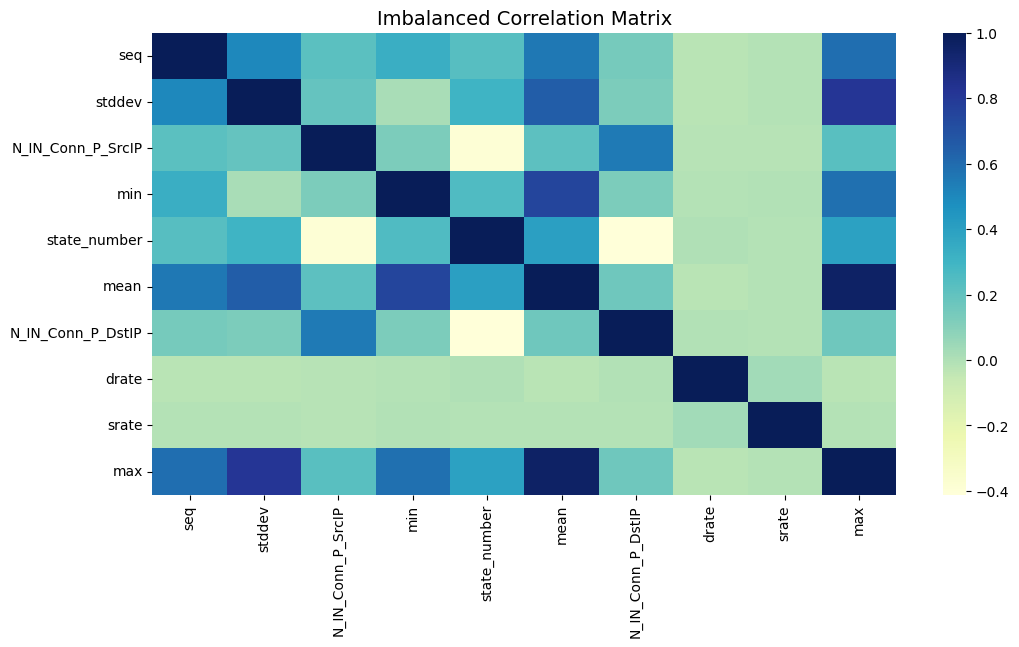

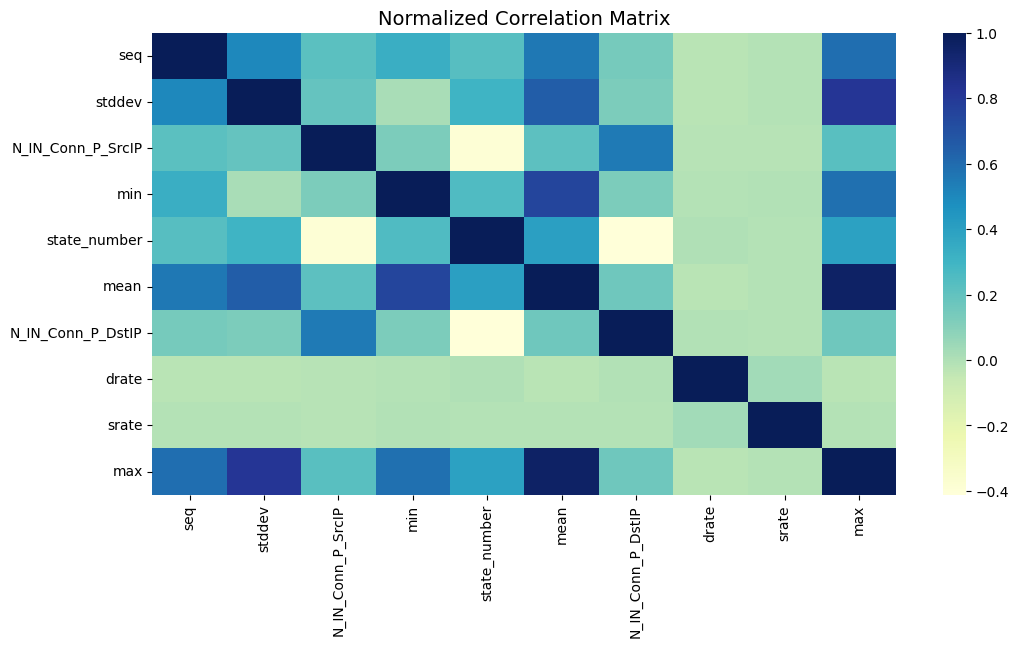

In [ ]:
# Select only numeric columns for correlation calculation
numeric_cols = normalized_full_df.select_dtypes(include=['float64', 'int64'])

# Sample figsize in inches
fig, ax = plt.subplots(figsize=(12, 6))
fig, ax1 = plt.subplots(figsize=(12, 6))

# Imbalanced DataFrame Correlation
corr = numeric_cols.corr()
sns.heatmap(corr, cmap="YlGnBu", annot_kws={"size": 30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)

# Correlation Matrix after Normalization
corr2 = numeric_cols.corr()
sns.heatmap(corr2, cmap="YlGnBu", annot_kws={"size": 30}, ax=ax1)
ax1.set_title("Normalized Correlation Matrix", fontsize=14)

plt.show()

In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import sys
import pickle

# Train Random Forest Classifier
start_train = time.time()
rfc = RandomForestClassifier(n_estimators=10, random_state=42).fit(X_Train, Y_Train)  # Ensure consistent random state
train_time = time.time() - start_train

# Measure prediction time
start_test = time.time()
prediction_forest = rfc.predict(X_Test)  # Store predictions in prediction_forest
test_time = time.time() - start_test

# Print classification report, accuracy, model size, training and prediction time
print(classification_report(Y_Test, prediction_forest, target_names=le.inverse_transform(rfc.classes_), digits=3))
print(f"Accuracy: {rfc.score(X_Test, Y_Test):.3f}")
print(f"Model size: {sys.getsizeof(pickle.dumps(rfc))} bytes")
print(f"Training Time: {train_time:.2f}s, Prediction Time: {test_time:.2f}s")

# Generate and print confusion matrix
cm_forest = confusion_matrix(Y_Test, prediction_forest)
print(cm_forest)

                   precision    recall  f1-score   support

Data_Exfiltration      1.000     1.000     1.000         2
         DoS&DDoS      1.000     1.000     1.000     14489
       Keylogging      0.923     1.000     0.960        12
           Normal      0.986     0.948     0.967        77
   OS_Fingerprint      0.921     0.914     0.917      3634
     Service_Scan      0.979     0.981     0.980     14713

         accuracy                          0.982     32927
        macro avg      0.968     0.974     0.971     32927
     weighted avg      0.982     0.982     0.982     32927

Accuracy: 0.982
Model size: 6372632 bytes
Training Time: 1.69s, Prediction Time: 0.02s
[[    2     0     0     0     0     0]
 [    0 14489     0     0     0     0]
 [    0     0    12     0     0     0]
 [    0     1     0    73     1     2]
 [    0     1     1     0  3322   310]
 [    0     0     0     1   285 14427]]


In [ ]:
feat_importances = pd.Series(rfc.feature_importances_, index= X.columns).sort_values(ascending=False)
fig = px.bar(d, x=feat_importances.index, y=feat_importances.values,title = 'Feature Importance using RF',labels = {'x':'Feature','y':'Importance'},color=feat_importances.values,text_auto=False)
fig.update_layout(title_x=0.5,width=1000, height=400)
fig.show()

                   precision    recall  f1-score   support

Data_Exfiltration      0.000     0.000     0.000         2
         DoS&DDoS      0.998     0.953     0.975     14489
       Keylogging      0.000     0.000     0.000        12
           Normal      0.444     0.260     0.328        77
   OS_Fingerprint      0.045     0.001     0.001      3634
     Service_Scan      0.772     0.997     0.870     14713

         accuracy                          0.866     32927
        macro avg      0.377     0.368     0.362     32927
     weighted avg      0.790     0.866     0.819     32927

Accuracy: 0.8656725483645641
Model size: 1304 bytes
Training Time: 5.24s, Testing Time: 0.00s, Average Prediction Time per Instance: 0.00569s
[[    0     0     0     2     0     0]
 [    0 13814     1     2    39   633]
 [    0     0     0     0     0    12]
 [    0     1     0    20     0    56]
 [    0    10     0     2     2  3620]
 [    0    23     0    19     3 14668]]


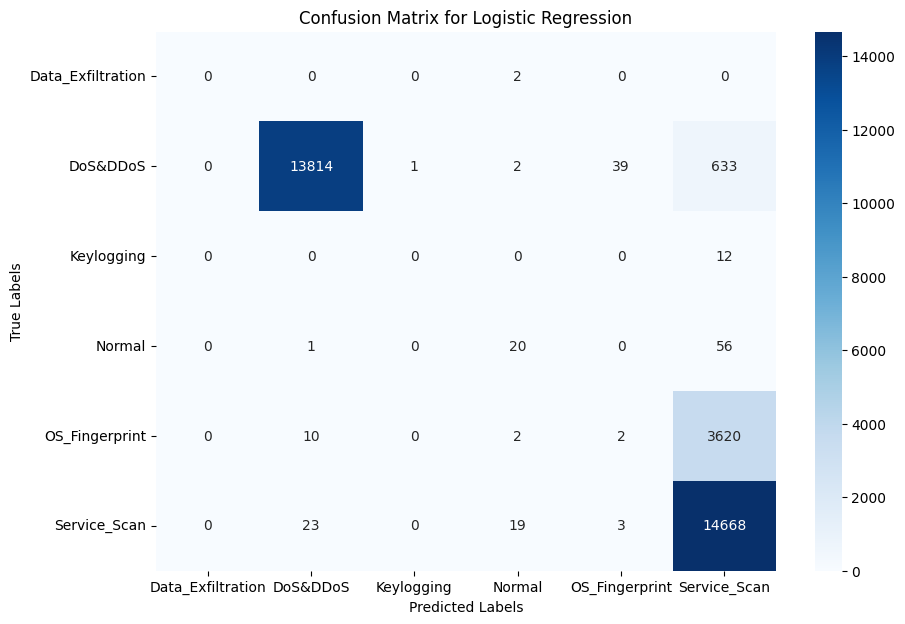

In [ ]:
from sklearn.linear_model import LogisticRegression
import pickle
import sys
import time
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Initialize the Logistic Regression model
lr = LogisticRegression(max_iter=1000, random_state=42)  # Adjust max_iter if needed

# Measure training time
start_train_time = time.time()
lr.fit(X_Train, Y_Train)
train_time = time.time() - start_train_time

# Measure testing time
start_test_time = time.time()
predictions = lr.predict(X_Test)
test_time = time.time() - start_test_time

# Calculate average prediction time per instance
start_instance_time = time.time()
instance_times = [time.time() - start_instance_time for _ in X_Test]
avg_prediction_time = np.mean(instance_times)

# Print accuracy and classification report
print(classification_report(Y_Test, predictions, target_names=le.inverse_transform(lr.classes_), digits=3))
print(f"Accuracy: {lr.score(X_Test, Y_Test)}")
print(f"Model size: {sys.getsizeof(pickle.dumps(lr))} bytes")
print(f"Training Time: {train_time:.2f}s, Testing Time: {test_time:.2f}s, Average Prediction Time per Instance: {avg_prediction_time:.5f}s")

# Generate and print confusion matrix
cm_lr = confusion_matrix(Y_Test, predictions)
print(cm_lr)

# Optionally, plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=le.inverse_transform(lr.classes_), yticklabels=le.inverse_transform(lr.classes_))
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Measure training time
start_train_time = time.time()
knn_model.fit(X_Train, Y_Train)
train_time = time.time() - start_train_time

# Measure testing time
start_test_time = time.time()
prediction_knn = knn_model.predict(X_Test)
test_time = time.time() - start_test_time

# Measure prediction time per instance
start_pred_time = time.time()
for instance in X_Test:
    knn_model.predict([instance])
avg_pred_time = (time.time() - start_pred_time) / len(X_Test)

# Print accuracy and classification report
print(classification_report(Y_Test, prediction_knn, target_names=le.inverse_transform(knn_model.classes_), digits=3))
print(f"Accuracy: {knn_model.score(X_Test, Y_Test)}")
print(f"Model size: {sys.getsizeof(pickle.dumps(knn_model))} bytes")
print(f"Training Time: {train_time:.2f}s, Testing Time: {test_time:.2f}s, Average Prediction Time per Instance: {avg_pred_time:.5f}s")

# Generate and print confusion matrix
cm_knn = confusion_matrix(Y_Test, prediction_knn)
print(cm_knn)

                   precision    recall  f1-score   support

Data_Exfiltration      0.000     0.000     0.000         2
         DoS&DDoS      0.998     0.995     0.996     14489
       Keylogging      0.857     1.000     0.923        12
           Normal      0.974     0.961     0.967        77
   OS_Fingerprint      0.937     0.936     0.937      3634
     Service_Scan      0.982     0.985     0.984     14713

         accuracy                          0.984     32927
        macro avg      0.791     0.813     0.801     32927
     weighted avg      0.984     0.984     0.984     32927

Accuracy: 0.9838430467397576
Model size: 14217538 bytes
Training Time: 0.26s, Testing Time: 5.17s, Average Prediction Time per Instance: 0.00115s
[[    0     0     2     0     0     0]
 [    0 14414     0     1    29    45]
 [    0     0    12     0     0     0]
 [    0     0     0    74     0     3]
 [    0    15     0     0  3401   218]
 [    0    19     0     1   199 14494]]


In [ ]:
%%time

svmclf = svm.SVC(random_state=42).fit(X_Train,Y_Train)  #SMOTE: X_Smote_Train,Y_Smote_Train
predictions_svm = svmclf.predict(X_Test)
print(classification_report(Y_Test,predictions_svm,target_names = le.inverse_transform(svmclf.classes_),digits=3))
print(f"Accuracy: {svmclf.score(X_Test, Y_Test)}")
print(f"Model size: {sys.getsizeof(pickle.dumps(svmclf))} bytes")

cm_svm = confusion_matrix(Y_Test, predictions_svm)
print(cm_svm)


                   precision    recall  f1-score   support

Data_Exfiltration      0.000     0.000     0.000         2
         DoS&DDoS      0.989     0.987     0.988     14489
       Keylogging      0.500     0.167     0.250        12
           Normal      0.775     0.896     0.831        77
   OS_Fingerprint      0.708     0.210     0.324      3634
     Service_Scan      0.829     0.974     0.896     14713

         accuracy                          0.895     32927
        macro avg      0.634     0.539     0.548     32927
     weighted avg      0.886     0.895     0.873     32927

Accuracy: 0.8949798038084247
Model size: 3883068 bytes
[[    0     0     2     0     0     0]
 [    0 14304     0     3    31   151]
 [    0     0     2     0     0    10]
 [    0     2     0    69     4     2]
 [    0    70     0     3   762  2799]
 [    0    88     0    14   279 14332]]
CPU times: user 4min 58s, sys: 582 ms, total: 4min 59s
Wall time: 4min 58s


In [ ]:
import time
import pickle
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import sys

# Train SVM Classifier
start_train = time.time()
svmclf = svm.SVC(random_state=42).fit(X_Train, Y_Train)  # Ensure consistent random state
train_time = time.time() - start_train

# Measure prediction time
start_test = time.time()
predictions_svm = svmclf.predict(X_Test)  # Store predictions in predictions_svm
test_time = time.time() - start_test

# Print classification report, accuracy, model size, training and prediction time
print(classification_report(Y_Test, predictions_svm, target_names=le.inverse_transform(svmclf.classes_), digits=3))
print(f"Accuracy: {svmclf.score(X_Test, Y_Test):.3f}")
print(f"Model size: {sys.getsizeof(pickle.dumps(svmclf))} bytes")
print(f"Training Time: {train_time:.2f}s, Prediction Time: {test_time:.2f}s")

# Generate and print confusion matrix
cm_svm = confusion_matrix(Y_Test, predictions_svm)
print(cm_svm)

                   precision    recall  f1-score   support

Data_Exfiltration      0.000     0.000     0.000         2
         DoS&DDoS      0.989     0.987     0.988     14489
       Keylogging      0.500     0.167     0.250        12
           Normal      0.775     0.896     0.831        77
   OS_Fingerprint      0.708     0.210     0.324      3634
     Service_Scan      0.829     0.974     0.896     14713

         accuracy                          0.895     32927
        macro avg      0.634     0.539     0.548     32927
     weighted avg      0.886     0.895     0.873     32927

Accuracy: 0.895
Model size: 3883068 bytes
Training Time: 146.94s, Prediction Time: 38.78s
[[    0     0     2     0     0     0]
 [    0 14304     0     3    31   151]
 [    0     0     2     0     0    10]
 [    0     2     0    69     4     2]
 [    0    70     0     3   762  2799]
 [    0    88     0    14   279 14332]]


In [ ]:
from sklearn.naive_bayes import GaussianNB
import time
import sys
import pickle
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the Naive Bayes model
nb_model = GaussianNB()

# Measure training time
start_train_time = time.time()
nb_model.fit(X_Train, Y_Train)
train_time = time.time() - start_train_time

# Measure testing time
start_test_time = time.time()
prediction_nb = nb_model.predict(X_Test)
test_time = time.time() - start_test_time

# Measure prediction time per instance
start_pred_time = time.time()
for instance in X_Test:
    nb_model.predict([instance])
avg_pred_time = (time.time() - start_pred_time) / len(X_Test)

# Print accuracy and classification report
print(classification_report(Y_Test, prediction_nb, target_names=le.inverse_transform(nb_model.classes_), digits=3))
print(f"Accuracy: {nb_model.score(X_Test, Y_Test)}")
print(f"Model size: {sys.getsizeof(pickle.dumps(nb_model))} bytes")
print(f"Training Time: {train_time:.2f}s, Testing Time: {test_time:.2f}s, Average Prediction Time per Instance: {avg_pred_time:.5f}s")

# Generate and print confusion matrix
cm_nb = confusion_matrix(Y_Test, prediction_nb)
print(cm_nb)

                   precision    recall  f1-score   support

Data_Exfiltration      1.000     1.000     1.000         2
         DoS&DDoS      0.746     0.986     0.850     14489
       Keylogging      0.308     1.000     0.471        12
           Normal      0.276     0.208     0.237        77
   OS_Fingerprint      0.372     0.589     0.456      3634
     Service_Scan      0.888     0.477     0.621     14713

         accuracy                          0.713     32927
        macro avg      0.598     0.710     0.606     32927
     weighted avg      0.767     0.713     0.702     32927

Accuracy: 0.7131837094178031
Model size: 1672 bytes
Training Time: 0.04s, Testing Time: 0.01s, Average Prediction Time per Instance: 0.00018s
[[    2     0     0     0     0     0]
 [    0 14293     0     2    65   129]
 [    0     0    12     0     0     0]
 [    0     3     0    16     0    58]
 [    0   777     5     9  2142   701]
 [    0  4087    22    31  3555  7018]]


                   precision    recall  f1-score   support

Data_Exfiltration      1.000     1.000     1.000         2
         DoS&DDoS      1.000     0.998     0.999     14489
       Keylogging      1.000     0.167     0.286        12
           Normal      0.980     0.636     0.772        77
   OS_Fingerprint      0.766     0.784     0.775      3634
     Service_Scan      0.942     0.941     0.942     14713

         accuracy                          0.948     32927
        macro avg      0.948     0.754     0.795     32927
     weighted avg      0.948     0.948     0.948     32927

Accuracy: 0.9477024933944787
Model size: 29545 bytes
Training Time: 0.93s, Testing Time: 0.00s
[[    2     0     0     0     0     0]
 [    0 14459     0     0     6    24]
 [    0     0     2     0     0    10]
 [    0     1     0    49     0    27]
 [    0     1     0     0  2849   784]
 [    0     3     0     1   865 13844]]


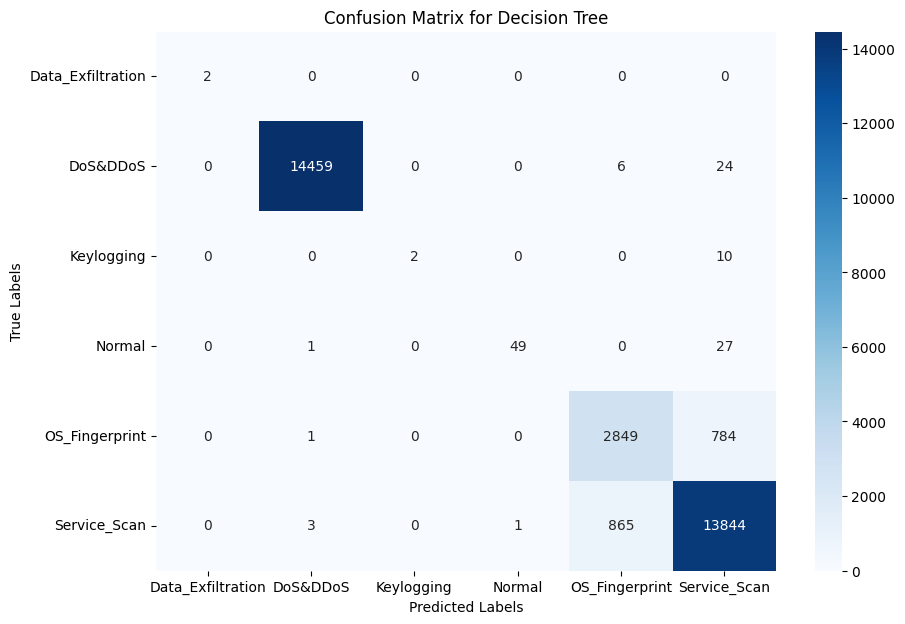

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import pickle
import sys
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the Decision Tree model
dtc = DecisionTreeClassifier(random_state=42, max_depth=10)  # Adjust max_depth as needed

# Measure training time
start_train_time = time.time()
dtc.fit(X_Train, Y_Train)
train_time = time.time() - start_train_time

# Measure testing time
start_test_time = time.time()
prediction_tree = dtc.predict(X_Test)
test_time = time.time() - start_test_time

# Print accuracy and classification report
print(classification_report(Y_Test, prediction_tree, target_names=le.inverse_transform(dtc.classes_), digits=3))
print(f"Accuracy: {dtc.score(X_Test, Y_Test)}")
print(f"Model size: {sys.getsizeof(pickle.dumps(dtc))} bytes")
print(f"Training Time: {train_time:.2f}s, Testing Time: {test_time:.2f}s")

# Generate and print confusion matrix
cm_tree = confusion_matrix(Y_Test, prediction_tree)
print(cm_tree)

# Optionally, plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Blues", xticklabels=le.inverse_transform(dtc.classes_), yticklabels=le.inverse_transform(dtc.classes_))
plt.title("Confusion Matrix for Decision Tree")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

                   precision    recall  f1-score   support

Data_Exfiltration      1.000     1.000     1.000         2
         DoS&DDoS      1.000     0.998     0.999     14489
       Keylogging      1.000     0.167     0.286        12
           Normal      0.980     0.636     0.772        77
   OS_Fingerprint      0.766     0.784     0.775      3634
     Service_Scan      0.942     0.941     0.942     14713

         accuracy                          0.948     32927
        macro avg      0.948     0.754     0.795     32927
     weighted avg      0.948     0.948     0.948     32927

Accuracy: 0.948
Model size: 29545 bytes
Training Time: 0.74s, Prediction Time: 0.00s
[[    2     0     0     0     0     0]
 [    0 14459     0     0     6    24]
 [    0     0     2     0     0    10]
 [    0     1     0    49     0    27]
 [    0     1     0     0  2849   784]
 [    0     3     0     1   865 13844]]


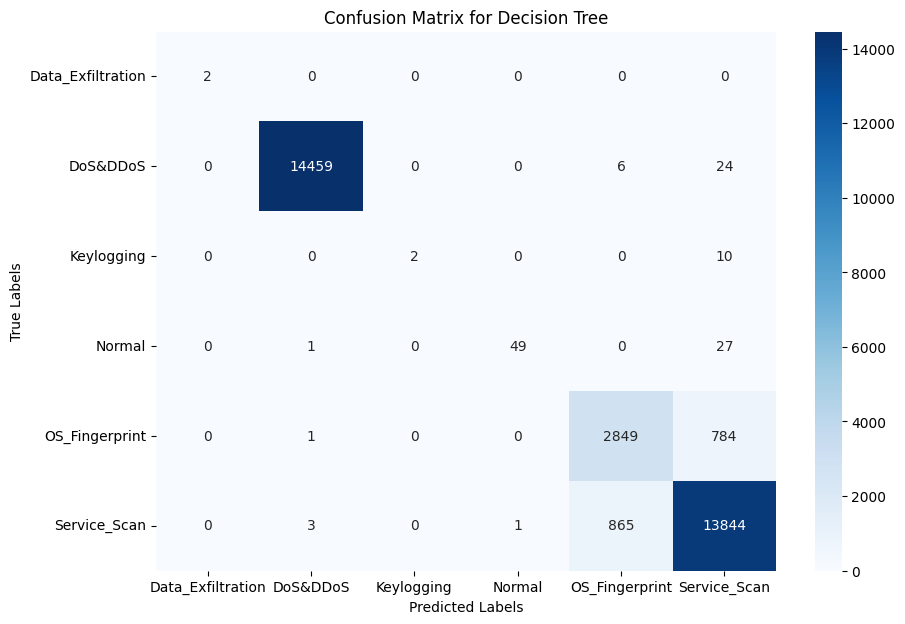

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import pickle
import sys
from sklearn.metrics import classification_report, confusion_matrix
import time

# Initialize the Decision Tree model
dtc = DecisionTreeClassifier(random_state=42, max_depth=10)  # Adjust max_depth as needed

# Measure training time
start_train_time = time.time()
dtc.fit(X_Train, Y_Train)
train_time = time.time() - start_train_time

# Measure prediction time
start_test_time = time.time()
prediction_tree = dtc.predict(X_Test)
test_time = time.time() - start_test_time

# Print accuracy and classification report
print(classification_report(Y_Test, prediction_tree, target_names=le.inverse_transform(dtc.classes_), digits=3))
print(f"Accuracy: {dtc.score(X_Test, Y_Test):.3f}")
print(f"Model size: {sys.getsizeof(pickle.dumps(dtc))} bytes")
print(f"Training Time: {train_time:.2f}s, Prediction Time: {test_time:.2f}s")

# Generate and print confusion matrix
cm_tree = confusion_matrix(Y_Test, prediction_tree)
print(cm_tree)

# Optionally, plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Blues", xticklabels=le.inverse_transform(dtc.classes_), yticklabels=le.inverse_transform(dtc.classes_))
plt.title("Confusion Matrix for Decision Tree")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Initialize Decision Tree classifier
dtc = DecisionTreeClassifier(random_state=42, max_depth=10)

# Perform cross-validation
scores_dtc = cross_val_score(dtc, X_Train, Y_Train, cv=5, scoring='f1_weighted')
print("Decision Tree Cross-Validation Mean F1-Score:", scores_dtc.mean())
print("Decision Tree Cross-Validation Standard Deviation:", scores_dtc.std())

Decision Tree Cross-Validation Mean F1-Score: 0.947090261645779
Decision Tree Cross-Validation Standard Deviation: 0.00119264291463651


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np

# Initialize classifiers
svc = SVC(random_state=42)
rfc = RandomForestClassifier(n_estimators=10, random_state=42)

# Perform cross-validation for SVM
scores_svc = cross_val_score(svc, X_Train, Y_Train, cv=5, scoring='f1_weighted')
print("SVM Cross-Validation Mean F1-Score:", scores_svc.mean())
print("SVM Cross-Validation Standard Deviation:", scores_svc.std())

# Perform cross-validation for Random Forest
scores_rfc = cross_val_score(rfc, X_Train, Y_Train, cv=5, scoring='f1_weighted')
print("Random Forest Cross-Validation Mean F1-Score:", scores_rfc.mean())
print("Random Forest Cross-Validation Standard Deviation:", scores_rfc.std())

SVM Cross-Validation Mean F1-Score: 0.8727927512957583
SVM Cross-Validation Standard Deviation: 0.0011849671116718106
Random Forest Cross-Validation Mean F1-Score: 0.9822037240833849
Random Forest Cross-Validation Standard Deviation: 0.0010049924900154344


Classification Report for Hybrid Model (DT-CART + XGBoost):
                   precision    recall  f1-score   support

Data_Exfiltration       1.00      1.00      1.00         2
         DoS&DDoS       1.00      1.00      1.00     14489
       Keylogging       1.00      1.00      1.00        12
           Normal       1.00      0.99      0.99        77
   OS_Fingerprint       0.92      0.88      0.90      3634
     Service_Scan       0.97      0.98      0.98     14713

         accuracy                           0.98     32927
        macro avg       0.98      0.97      0.98     32927
     weighted avg       0.98      0.98      0.98     32927



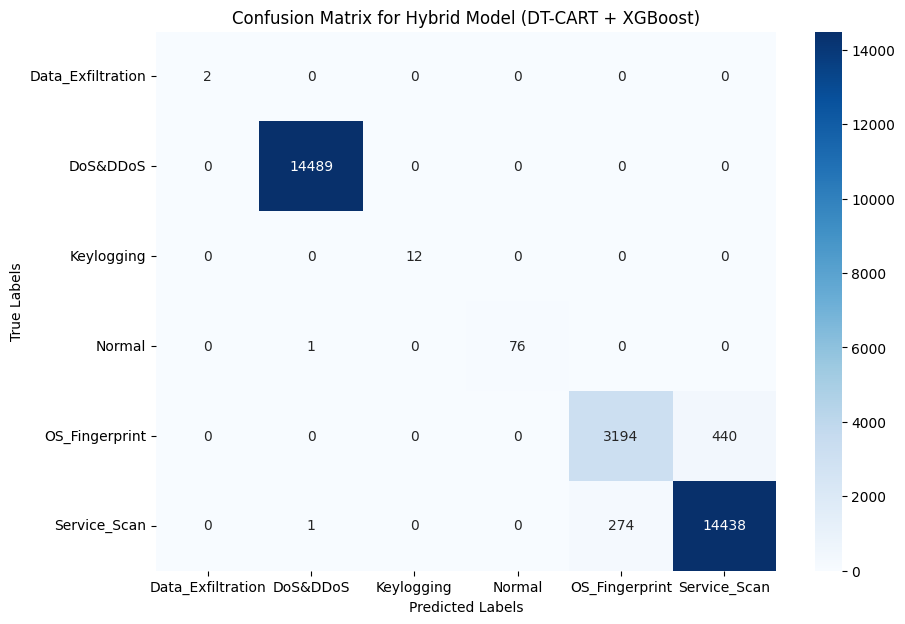

In [ ]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the hybrid model function
def train_hybrid_model(X_train, y_train):
    # Step 1: Train the Decision Tree model to generate additional features
    cart_model = DecisionTreeClassifier(random_state=42, max_depth=10)
    cart_model.fit(X_train, y_train)

    # Generate CART predictions as additional features for XGBoost
    X_train_cart_pred = cart_model.predict(X_train).reshape(-1, 1)
    X_train_hybrid = np.concatenate((X_train, X_train_cart_pred), axis=1)

    # Step 2: Train the XGBoost model on the combined features
    xgb_model = XGBClassifier(n_estimators=50, max_depth=5, random_state=42, tree_method='hist')
    xgb_model.fit(X_train_hybrid, y_train)

    return xgb_model, cart_model

# Train the hybrid model
xgb_model, cart_model = train_hybrid_model(X_Train, Y_Train)

# Generate predictions for the test set
# Step 1: Generate CART predictions as additional features for the test set
X_test_cart_pred = cart_model.predict(X_Test).reshape(-1, 1)
X_test_hybrid = np.concatenate((X_Test, X_test_cart_pred), axis=1)

# Step 2: Use the trained XGBoost model to predict on the hybrid test set
y_pred_hybrid = xgb_model.predict(X_test_hybrid)

# Step 3: Generate confusion matrix and classification report
conf_matrix = confusion_matrix(Y_Test, y_pred_hybrid)
class_report = classification_report(Y_Test, y_pred_hybrid, target_names=le.classes_)

# Display the classification report
print("Classification Report for Hybrid Model (DT-CART + XGBoost):")
print(class_report)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for Hybrid Model (DT-CART + XGBoost)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Define the hybrid model function
def train_hybrid_model(X_train, y_train):
    # Step 1: Train the Decision Tree model to generate additional features
    cart_model = DecisionTreeClassifier(random_state=42, max_depth=10)
    cart_model.fit(X_train, y_train)

    # Generate CART predictions as additional features for XGBoost
    X_train_cart_pred = cart_model.predict(X_train).reshape(-1, 1)
    X_train_hybrid = np.concatenate((X_train, X_train_cart_pred), axis=1)

    # Step 2: Train the XGBoost model on the combined features
    xgb_model = XGBClassifier(n_estimators=50, max_depth=5, random_state=42, tree_method='hist')
    xgb_model.fit(X_train_hybrid, y_train)

    return xgb_model

# Custom function for cross-validation on hybrid model
def cross_val_hybrid_model(X, y, cv=5):
    scores = []
    for train_index, test_index in StratifiedKFold(n_splits=cv, shuffle=True, random_state=42).split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the hybrid model
        model = train_hybrid_model(X_train, y_train)

        # Generate CART predictions for test set to match hybrid training
        cart_model = DecisionTreeClassifier(random_state=42, max_depth=10)
        cart_model.fit(X_train, y_train)
        X_test_cart_pred = cart_model.predict(X_test).reshape(-1, 1)
        X_test_hybrid = np.concatenate((X_test, X_test_cart_pred), axis=1)

        # Evaluate the model
        score = model.score(X_test_hybrid, y_test)
        scores.append(score)

    return np.mean(scores), np.std(scores)

# Assuming 'X_Train' and 'Y_Train' are already defined
mean_score, std_score = cross_val_hybrid_model(X_Train, Y_Train, cv=5)
print(f"Hybrid Model Cross-Validation Mean Accuracy: {mean_score:.4f}")
print(f"Hybrid Model Cross-Validation Std Deviation: {std_score:.4f}")

Hybrid Model Cross-Validation Mean Accuracy: 0.9779
Hybrid Model Cross-Validation Std Deviation: 0.0012


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Define the classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),  # Adjust kernel if needed
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Cross-validation parameters
cv_folds = 5  # Number of folds for cross-validation

# Perform cross-validation for each classifier
for name, clf in classifiers.items():
    print(f"\n{name} Cross-Validation Results ---")
    scores = cross_val_score(clf, X_Train, Y_Train, cv=cv_folds, scoring='accuracy')
    print(f"Cross-Validation Scores: {scores}")
    print(f"Average CV Score: {scores.mean():.4f}")


Logistic Regression Cross-Validation Results ---
Cross-Validation Scores: [0.86595042 0.86564671 0.86735507 0.86777267 0.86579347]
Average CV Score: 0.8665

K-Nearest Neighbors Cross-Validation Results ---
Cross-Validation Scores: [0.98295433 0.98359971 0.9824608  0.98227098 0.9841306 ]
Average CV Score: 0.9831

Naive Bayes Cross-Validation Results ---
Cross-Validation Scores: [0.70392164 0.69473444 0.70680688 0.70509852 0.71970387]
Average CV Score: 0.7061

Random Forest Cross-Validation Results ---
Cross-Validation Scores: [0.98253673 0.98481455 0.98416917 0.98291637 0.9848899 ]
Average CV Score: 0.9839

SVM Cross-Validation Results ---
Cross-Validation Scores: [0.86765878 0.86689951 0.86875973 0.86986067 0.86617312]
Average CV Score: 0.8679

Decision Tree Cross-Validation Results ---
Cross-Validation Scores: [0.98807942 0.9887248  0.98815535 0.98857295 0.98819286]
Average CV Score: 0.9883


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# Parameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [ ]:
def train_hybrid_model(X_train, y_train, dt_params={}, xgb_params={}):
    # Step 1: Train the Decision Tree model with the provided parameters
    cart_model = DecisionTreeClassifier(random_state=42, **dt_params)
    cart_model.fit(X_train, y_train)

    # Generate CART predictions as additional features for XGBoost
    X_train_cart_pred = cart_model.predict(X_train).reshape(-1, 1)
    X_train_hybrid = np.concatenate((X_train, X_train_cart_pred), axis=1)

    # Step 2: Train the XGBoost model with the provided parameters
    xgb_model = XGBClassifier(random_state=42, tree_method='hist', **xgb_params)
    xgb_model.fit(X_train_hybrid, y_train)

    return xgb_model, cart_model

In [ ]:
from sklearn.model_selection import ParameterGrid

# Define the function for tuning and cross-validation
def tune_and_validate_hybrid_model(X_train, y_train, param_grid_dt, param_grid_xgb, cv=3, n_iter=10):
    best_score = 0
    best_params = {}

    # RandomizedSearchCV for Decision Tree
    for dt_params in ParameterGrid(param_grid_dt):
        cart_model = DecisionTreeClassifier(random_state=42, **dt_params)
        cart_model.fit(X_train, y_train)

        # Generate CART predictions
        X_train_cart_pred = cart_model.predict(X_train).reshape(-1, 1)
        X_train_hybrid = np.concatenate((X_train, X_train_cart_pred), axis=1)

        # RandomizedSearchCV for XGBoost with the given parameters
        xgb_search = RandomizedSearchCV(
            estimator=XGBClassifier(random_state=42, tree_method='hist'),
            param_distributions=param_grid_xgb,
            scoring='f1_weighted',
            cv=cv,
            n_iter=n_iter,
            verbose=2,
            random_state=42,
            n_jobs=-1
        )

        xgb_search.fit(X_train_hybrid, y_train)

        if xgb_search.best_score_ > best_score:
            best_score = xgb_search.best_score_
            best_params = {'dt_params': dt_params, 'xgb_params': xgb_search.best_params_}

    print(f"Best Score: {best_score}")
    print(f"Best Parameters: {best_params}")
    return best_params

# Run the tuning process
best_params = tune_and_validate_hybrid_model(X_Train, Y_Train, param_grid_dt, param_grid_xgb)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each

Training Time for Tuned Hybrid Model: 4.7322 seconds
Prediction Time for Tuned Hybrid Model: 0.0551 seconds
Classification Report for Tuned Hybrid Model (DT-CART + XGBoost):
                   precision    recall  f1-score   support

Data_Exfiltration       1.00      1.00      1.00         2
         DoS&DDoS       1.00      1.00      1.00     14489
       Keylogging       0.92      1.00      0.96        12
           Normal       0.99      0.96      0.97        77
   OS_Fingerprint       0.93      0.92      0.93      3634
     Service_Scan       0.98      0.98      0.98     14713

         accuracy                           0.98     32927
        macro avg       0.97      0.98      0.97     32927
     weighted avg       0.98      0.98      0.98     32927



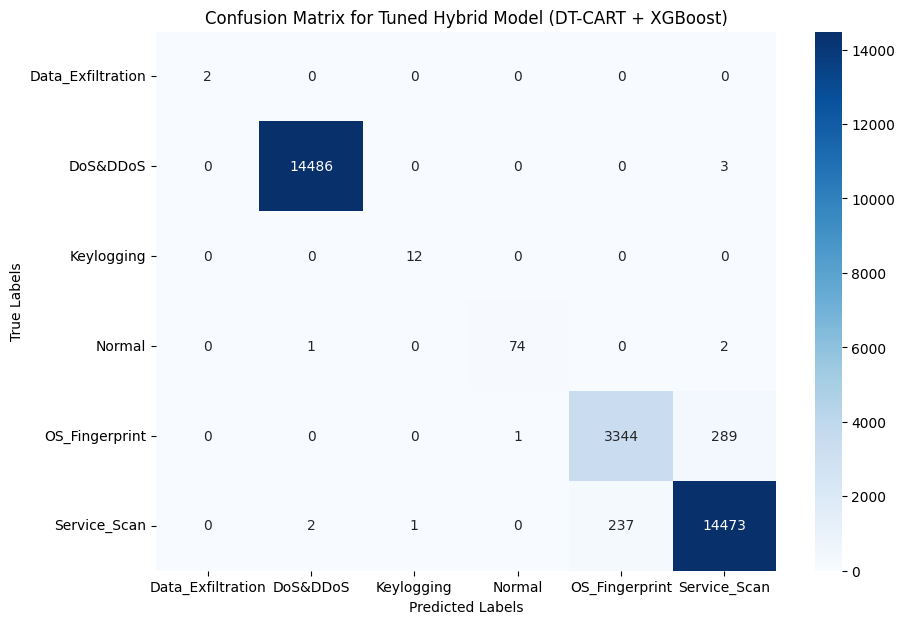

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

# Set the best parameters for Decision Tree and XGBoost
best_dt_params = {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
best_xgb_params = {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1}

# Define the function to train the hybrid model with tuned parameters
def train_tuned_hybrid_model(X_train, y_train):
    # Step 1: Train the Decision Tree model to generate additional features
    cart_model = DecisionTreeClassifier(random_state=42, **best_dt_params)
    cart_model.fit(X_train, y_train)

    # Generate CART predictions as additional features for XGBoost
    X_train_cart_pred = cart_model.predict(X_train).reshape(-1, 1)
    X_train_hybrid = np.concatenate((X_train, X_train_cart_pred), axis=1)

    # Step 2: Train the XGBoost model on the combined features
    xgb_model = XGBClassifier(random_state=42, tree_method='hist', **best_xgb_params)
    xgb_model.fit(X_train_hybrid, y_train)

    return xgb_model, cart_model

# Measure training time
start_training_time = time.time()
xgb_model_tuned, cart_model_tuned = train_tuned_hybrid_model(X_Train, Y_Train)
training_time = time.time() - start_training_time
print(f"Training Time for Tuned Hybrid Model: {training_time:.4f} seconds")

# Generate predictions for the test set
# Step 1: Generate CART predictions as additional features for the test set
X_test_cart_pred = cart_model_tuned.predict(X_Test).reshape(-1, 1)
X_test_hybrid = np.concatenate((X_Test, X_test_cart_pred), axis=1)

# Measure prediction time
start_prediction_time = time.time()
y_pred_hybrid = xgb_model_tuned.predict(X_test_hybrid)
prediction_time = time.time() - start_prediction_time
print(f"Prediction Time for Tuned Hybrid Model: {prediction_time:.4f} seconds")

# Step 3: Generate confusion matrix and classification report
conf_matrix = confusion_matrix(Y_Test, y_pred_hybrid)
class_report = classification_report(Y_Test, y_pred_hybrid, target_names=le.classes_)

# Display the classification report
print("Classification Report for Tuned Hybrid Model (DT-CART + XGBoost):")
print(class_report)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Tuned Hybrid Model (DT-CART + XGBoost)")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Define the function to cross-validate the tuned hybrid model
def cross_val_tuned_hybrid_model(X, Y, cv=5):
    # Use the tuned parameters for DT and XGBoost
    cart_model = DecisionTreeClassifier(random_state=42, **best_dt_params)
    xgb_model = XGBClassifier(random_state=42, tree_method='hist', **best_xgb_params)

    # Generate CART predictions as additional features for XGBoost
    cart_model.fit(X, Y)
    X_cart_pred = pd.DataFrame(cart_model.predict(X), columns=["Cart_Pred"])
    X_hybrid = pd.concat([pd.DataFrame(X), X_cart_pred], axis=1)

    # Cross-validate XGBoost on the hybrid features
    scores = cross_val_score(xgb_model, X_hybrid, Y, cv=cv, scoring="accuracy")
    print("Cross-Validation Scores for Tuned Hybrid Model (DT-CART + XGBoost):", scores)
    print("Mean CV Accuracy for Tuned Hybrid Model:", np.mean(scores))

# Run cross-validation for the Tuned Hybrid Model
cross_val_tuned_hybrid_model(X_Smote_Train, Y_Smote_Train)

Cross-Validation Scores for Tuned Hybrid Model (DT-CART + XGBoost): [0.99282263 0.99454235 0.9942581  0.99404483 0.99356159]
Mean CV Accuracy for Tuned Hybrid Model: 0.9938458999613943


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}
Best parameters for AdaBoost: {'learning_rate': 0.01, 'n_estimators': 50}
Classification Report for Ensemble Model (DT-CART + XGBoost + GradientBoosting + AdaBoost):
                   precision    recall  f1-score   support

Data_Exfiltration       1.00      1.00      1.00         2
         DoS&DDoS       1.00      1.00      1.00     14489
       Keylogging       1.00      1.00      1.00        12
           Normal       1.00      0.91      0.95        77
   OS_Fingerprint       0.97      0.86      0.91      3634
     Service_Scan       0.97      0.99      0.98     14713

         accuracy                           0.98     32927
        macro avg       0.99      0.96      0.97     32927
     weighted avg       0.98      0.98      0.98     32927



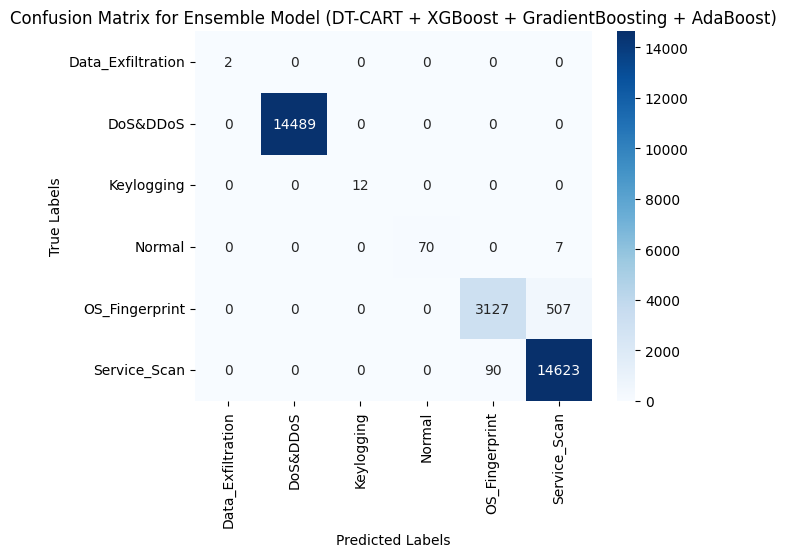

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Define parameter grid for Gradient Boosting and AdaBoost
param_grid_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

param_grid_ada = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5]
}

# Initialize models
gb = GradientBoostingClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)

# Grid search for Gradient Boosting
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=2)
grid_search_gb.fit(X_Train, Y_Train)
best_gb = grid_search_gb.best_estimator_

# Grid search for AdaBoost
grid_search_ada = GridSearchCV(estimator=ada, param_grid=param_grid_ada, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=2)
grid_search_ada.fit(X_Train, Y_Train)
best_ada = grid_search_ada.best_estimator_

print("Best parameters for Gradient Boosting:", grid_search_gb.best_params_)
print("Best parameters for AdaBoost:", grid_search_ada.best_params_)

# Ensemble with Voting Classifier
voting_ensemble = VotingClassifier(
    estimators=[('dt_cart_xgb', xgb_model), ('gradient_boosting', best_gb), ('adaboost', best_ada)],
    voting='soft'
)

# Train and evaluate ensemble model
voting_ensemble.fit(X_Train, Y_Train)
Y_Pred = voting_ensemble.predict(X_Test)

# Display classification report and confusion matrix
print("Classification Report for Ensemble Model (DT-CART + XGBoost + GradientBoosting + AdaBoost):")
print(classification_report(Y_Test, Y_Pred, target_names=le.classes_))

conf_matrix = confusion_matrix(Y_Test, Y_Pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for Ensemble Model (DT-CART + XGBoost + GradientBoosting + AdaBoost)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming you have your dataset normalized in `normalized_full_df`:
X = normalized_full_df.drop(columns=['subcategory'])
y = normalized_full_df['subcategory']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=3)
X_Smote_Train, y_Smote_Train = smote.fit_resample(X_train, y_train)

# Verify the SMOTE transformation
print(f"Before SMOTE: {Counter(y_train)}")
print(f"After SMOTE: {Counter(y_Smote_Train)}")

Before SMOTE: Counter({'Service_Scan': 58508, 'DoS&DDoS': 58421, 'OS_Fingerprint': 14369, 'Normal': 348, 'Keylogging': 54, 'Data_Exfiltration': 4})
After SMOTE: Counter({'DoS&DDoS': 58508, 'Service_Scan': 58508, 'OS_Fingerprint': 58508, 'Normal': 58508, 'Keylogging': 58508, 'Data_Exfiltration': 58508})


In [ ]:
# Number of clients for federated learning
num_clients = 5

# Split the balanced data into 'num_clients' parts
X_train_clients = np.array_split(X_Smote_Train, num_clients)  # Splits X_Smote_Train into 5 parts
y_train_clients = np.array_split(y_Smote_Train, num_clients)  # Similarly splits y_Smote_Train into 5 parts

# Check the shape of the split data
for i in range(num_clients):
    print(f"Client {i+1}:")
    print(f"X_train_clients[{i}]: {X_train_clients[i].shape}")
    print(f"y_train_clients[{i}]: {y_train_clients[i].shape}")

Client 1:
X_train_clients[0]: (70210, 10)
y_train_clients[0]: (70210,)
Client 2:
X_train_clients[1]: (70210, 10)
y_train_clients[1]: (70210,)
Client 3:
X_train_clients[2]: (70210, 10)
y_train_clients[2]: (70210,)
Client 4:
X_train_clients[3]: (70209, 10)
y_train_clients[3]: (70209,)
Client 5:
X_train_clients[4]: (70209, 10)
y_train_clients[4]: (70209,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

# Initialize and fit the LabelEncoder on the entire training set to cover all classes
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Encode labels for each client
y_train_clients_encoded = [le.transform(y_client) for y_client in y_train_clients]

# Define the number of classes for XGBoost
num_classes = len(le.classes_)  # Total number of classes across all clients

client_models = []
for i in range(num_clients):
    unique_classes = np.unique(y_train_clients_encoded[i])
    print(f"Training models for Client {i + 1} with unique labels {unique_classes}")

    # Initialize the models
    dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
    gb_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50)
    ada_model = AdaBoostClassifier(learning_rate=0.01, n_estimators=50)

    # Train the non-XGBoost models
    dt_model.fit(X_train_clients[i], y_train_clients_encoded[i])
    gb_model.fit(X_train_clients[i], y_train_clients_encoded[i])
    ada_model.fit(X_train_clients[i], y_train_clients_encoded[i])

    # Train XGBoost only if the client has all classes
    if set(range(num_classes)).issubset(unique_classes):
        xgb_model = XGBClassifier(n_estimators=100, max_depth=5, random_state=42, num_class=num_classes, objective="multi:softmax")
        xgb_model.fit(X_train_clients[i], y_train_clients_encoded[i])
        client_models.append([dt_model, xgb_model, gb_model, ada_model])
    else:
        print(f"Skipping XGBoost for Client {i + 1} due to missing classes.")
        client_models.append([dt_model, None, gb_model, ada_model])

print("Training completed for all clients.")

Training models for Client 1 with unique labels [0 1 2 3 4 5]
Training models for Client 2 with unique labels [0 1 2 3 4 5]
Training models for Client 3 with unique labels [0 1 2]
Skipping XGBoost for Client 3 due to missing classes.
Training models for Client 4 with unique labels [2 3]
Skipping XGBoost for Client 4 due to missing classes.
Training models for Client 5 with unique labels [3 4]
Skipping XGBoost for Client 5 due to missing classes.
Training completed for all clients.



Classification Report for Federated Ensemble Model:
                   precision    recall  f1-score   support

Data_Exfiltration       0.50      1.00      0.67         1
         DoS&DDoS       1.00      1.00      1.00     14701
       Keylogging       0.37      0.88      0.52        16
           Normal       0.52      1.00      0.68        82
   OS_Fingerprint       0.90      0.81      0.85      3513
     Service_Scan       0.96      0.97      0.96     14614

         accuracy                           0.97     32927
        macro avg       0.71      0.94      0.78     32927
     weighted avg       0.97      0.97      0.97     32927



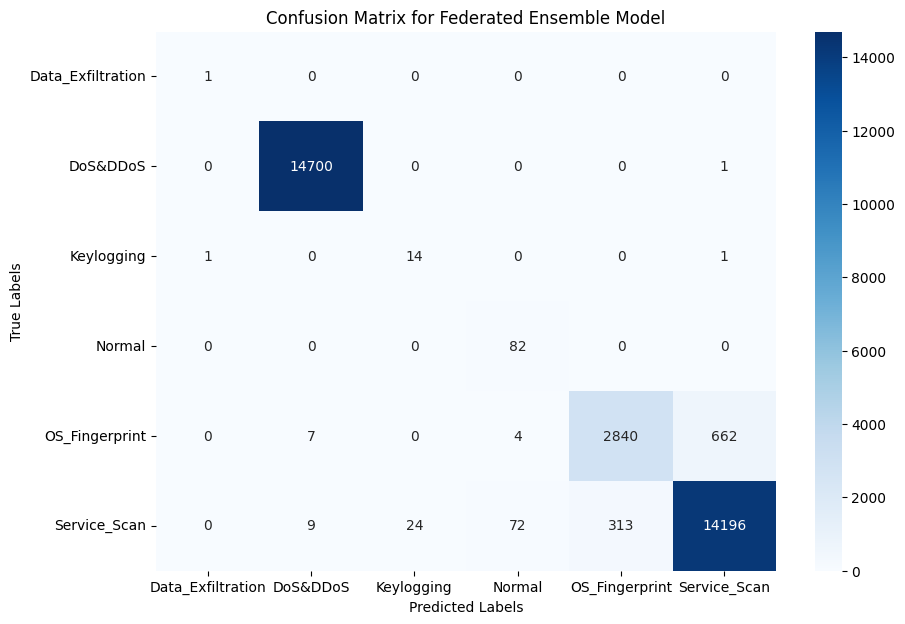

In [ ]:
# Convert final_predictions to string labels to match y_test's format
final_predictions_str = le.inverse_transform(final_predictions)

# Evaluate the aggregated predictions
print("\nClassification Report for Federated Ensemble Model:")
print(classification_report(y_test, final_predictions_str, target_names=le.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, final_predictions_str)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for Federated Ensemble Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Define the number of clients and initialize lists to store balanced data
num_clients = 5
X_train_clients_smote = []
y_train_clients_smote = []

for i in range(num_clients):
    # Calculate the minimum class size for the current client
    min_class_size = min(Counter(y_train_clients[i]).values())
    n_neighbors = min(3, max(min_class_size - 1, 1))  # Ensure n_neighbors is <= min_class_size - 1

    # Set up SMOTE with the adjusted n_neighbors
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=n_neighbors)

    print(f"Client {i + 1} - Before SMOTE: {Counter(y_train_clients[i])}")
    X_smote, y_smote = smote.fit_resample(X_train_clients[i], y_train_clients[i])
    print(f"Client {i + 1} - After SMOTE: {Counter(y_smote)}")

    # Append the balanced data for each client
    X_train_clients_smote.append(X_smote)
    y_train_clients_smote.append(y_smote)

Client 1 - Before SMOTE: Counter({'DoS&DDoS': 31230, 'Service_Scan': 31087, 'OS_Fingerprint': 7676, 'Normal': 184, 'Keylogging': 30, 'Data_Exfiltration': 3})
Client 1 - After SMOTE: Counter({'DoS&DDoS': 31230, 'Service_Scan': 31230, 'OS_Fingerprint': 31230, 'Normal': 31230, 'Keylogging': 31230, 'Data_Exfiltration': 31230})
Client 2 - Before SMOTE: Counter({'Service_Scan': 27421, 'DoS&DDoS': 27191, 'Data_Exfiltration': 8717, 'OS_Fingerprint': 6693, 'Normal': 164, 'Keylogging': 24})
Client 2 - After SMOTE: Counter({'DoS&DDoS': 27421, 'Service_Scan': 27421, 'OS_Fingerprint': 27421, 'Normal': 27421, 'Data_Exfiltration': 27421, 'Keylogging': 27421})
Client 3 - Before SMOTE: Counter({'Data_Exfiltration': 49788, 'Keylogging': 20335, 'DoS&DDoS': 87})
Client 3 - After SMOTE: Counter({'Data_Exfiltration': 49788, 'DoS&DDoS': 49788, 'Keylogging': 49788})
Client 4 - Before SMOTE: Counter({'Keylogging': 38119, 'Normal': 32090})
Client 4 - After SMOTE: Counter({'Keylogging': 38119, 'Normal': 38119})



Gathering predictions from Client 1...

Gathering predictions from Client 2...

Gathering predictions from Client 3...

Gathering predictions from Client 4...

Gathering predictions from Client 5...

Classification Report for Federated Ensemble Model:
                   precision    recall  f1-score   support

Data_Exfiltration       0.50      1.00      0.67         1
         DoS&DDoS       0.69      1.00      0.81     14701
       Keylogging       0.26      0.88      0.40        16
           Normal       0.04      1.00      0.08        82
   OS_Fingerprint       0.44      0.99      0.61      3513
     Service_Scan       1.00      0.12      0.22     14614

         accuracy                           0.61     32927
        macro avg       0.49      0.83      0.47     32927
     weighted avg       0.80      0.61      0.53     32927



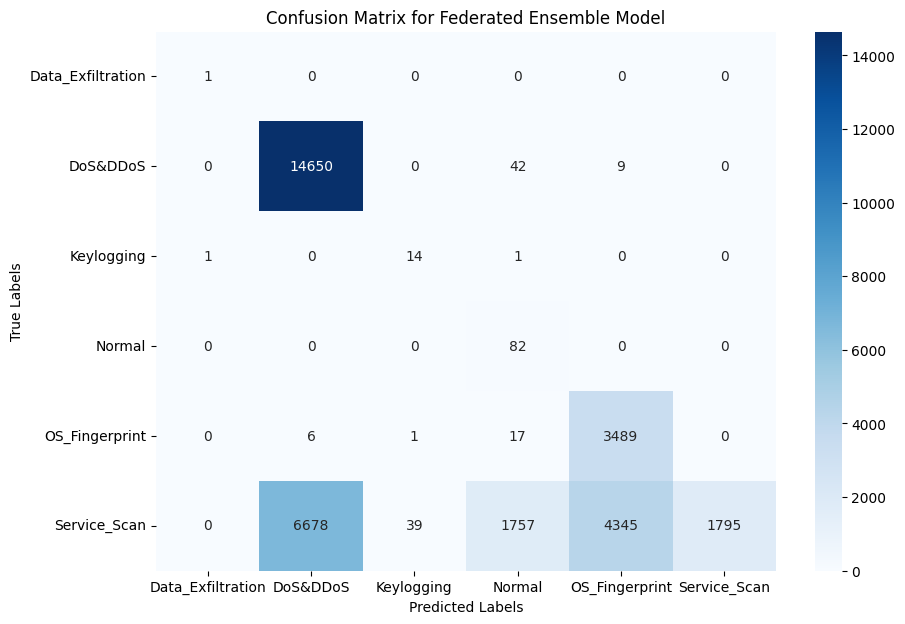

In [ ]:
# Convert client predictions to integer-encoded format
client_predictions = []

for i in range(num_clients):
    print(f"\nGathering predictions from Client {i + 1}...")

    # Predict using each model on the test data and encode predictions as integers
    dt_pred = le.transform(client_models[i][0].predict(X_test))
    gb_pred = le.transform(client_models[i][2].predict(X_test))
    ada_pred = le.transform(client_models[i][3].predict(X_test))

    if client_models[i][1] is not None:
        xgb_pred = le.transform(client_models[i][1].predict(X_test))
        client_predictions.append([dt_pred, xgb_pred, gb_pred, ada_pred])
    else:
        client_predictions.append([dt_pred, gb_pred, ada_pred])

# Majority Voting for Federated Aggregation
final_predictions = []
for j in range(len(X_test)):
    instance_predictions = [client_predictions[i][k][j] for i in range(num_clients) for k in range(len(client_predictions[i]))]
    final_predictions.append(np.bincount(instance_predictions).argmax())

# Convert final_predictions back to string labels for evaluation
final_predictions_str = le.inverse_transform(final_predictions)

# Evaluate the aggregated predictions
print("\nClassification Report for Federated Ensemble Model:")
print(classification_report(y_test, final_predictions_str, target_names=le.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, final_predictions_str)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for Federated Ensemble Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE

# Initialize and fit the LabelEncoder on the entire training set to cover all classes
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Define the number of classes for XGBoost
num_classes = len(le.classes_)

# SMOTE to balance each client’s data individually and encode after SMOTE
num_clients = 5
X_train_clients_smote = []
y_train_clients_smote_encoded = []

for i in range(num_clients):
    # Calculate the minimum class size for the current client's data
    min_class_size = min(Counter(y_train_clients[i]).values())
    # Set n_neighbors to a value no greater than min_class_size - 1
    n_neighbors = min(3, min_class_size - 1) if min_class_size > 1 else 1

    # Apply SMOTE to the client's data
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=n_neighbors)
    X_smote, y_smote = smote.fit_resample(X_train_clients[i], y_train_clients[i])

    # Encode the labels after SMOTE
    y_smote_encoded = le.transform(y_smote)

    # Append the balanced and encoded data for each client
    X_train_clients_smote.append(X_smote)
    y_train_clients_smote_encoded.append(y_smote_encoded)

# Initialize and train models for each client
client_models = []
for i in range(num_clients):
    unique_classes = np.unique(y_train_clients_smote_encoded[i])
    print(f"\nTraining models for Client {i + 1} with unique labels {unique_classes}")

    # Initialize the models
    dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
    gb_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50)
    ada_model = AdaBoostClassifier(learning_rate=0.01, n_estimators=50)

    # Train non-XGBoost models
    dt_model.fit(X_train_clients_smote[i], y_train_clients_smote_encoded[i])
    gb_model.fit(X_train_clients_smote[i], y_train_clients_smote_encoded[i])
    ada_model.fit(X_train_clients_smote[i], y_train_clients_smote_encoded[i])

    # Train XGBoost only if the client has all classes
    if set(range(num_classes)).issubset(unique_classes):
        xgb_model = XGBClassifier(n_estimators=100, max_depth=5, random_state=42, num_class=num_classes, objective="multi:softmax")
        xgb_model.fit(X_train_clients_smote[i], y_train_clients_smote_encoded[i])
        client_models.append([dt_model, xgb_model, gb_model, ada_model])
    else:
        print(f"Skipping XGBoost for Client {i + 1} due to missing classes.")
        client_models.append([dt_model, None, gb_model, ada_model])

print("\nTraining completed for all clients.")

# Proceed with aggregation and evaluation as previously structured.


Training models for Client 1 with unique labels [0 1 2 3 4 5]

Training models for Client 2 with unique labels [0 1 2 3 4 5]

Training models for Client 3 with unique labels [0 1 2]
Skipping XGBoost for Client 3 due to missing classes.

Training models for Client 4 with unique labels [2 3]
Skipping XGBoost for Client 4 due to missing classes.

Training models for Client 5 with unique labels [3 4]
Skipping XGBoost for Client 5 due to missing classes.

Training completed for all clients.


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Apply SMOTE to balance each client’s data individually
X_train_clients_smote = []
y_train_clients_smote = []

for i in range(num_clients):
    # Calculate the minimum class size for the current client
    min_class_size = min(Counter(y_train_clients[i]).values())
    n_neighbors = min(3, max(min_class_size - 1, 1))  # Ensure n_neighbors <= min_class_size - 1

    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=n_neighbors)

    print(f"\nClient {i + 1} - Before SMOTE: {Counter(y_train_clients[i])}")
    X_smote, y_smote = smote.fit_resample(X_train_clients[i], y_train_clients[i])
    y_smote_encoded = le.transform(y_smote)  # Encode the labels after SMOTE
    print(f"Client {i + 1} - After SMOTE: {Counter(y_smote)}")

    # Append the balanced data for each client
    X_train_clients_smote.append(X_smote)
    y_train_clients_smote.append(y_smote_encoded)


Client 1 - Before SMOTE: Counter({'DoS&DDoS': 31230, 'Service_Scan': 31087, 'OS_Fingerprint': 7676, 'Normal': 184, 'Keylogging': 30, 'Data_Exfiltration': 3})
Client 1 - After SMOTE: Counter({'DoS&DDoS': 31230, 'Service_Scan': 31230, 'OS_Fingerprint': 31230, 'Normal': 31230, 'Keylogging': 31230, 'Data_Exfiltration': 31230})

Client 2 - Before SMOTE: Counter({'Service_Scan': 27421, 'DoS&DDoS': 27191, 'Data_Exfiltration': 8717, 'OS_Fingerprint': 6693, 'Normal': 164, 'Keylogging': 24})
Client 2 - After SMOTE: Counter({'DoS&DDoS': 27421, 'Service_Scan': 27421, 'OS_Fingerprint': 27421, 'Normal': 27421, 'Data_Exfiltration': 27421, 'Keylogging': 27421})

Client 3 - Before SMOTE: Counter({'Data_Exfiltration': 49788, 'Keylogging': 20335, 'DoS&DDoS': 87})
Client 3 - After SMOTE: Counter({'Data_Exfiltration': 49788, 'DoS&DDoS': 49788, 'Keylogging': 49788})

Client 4 - Before SMOTE: Counter({'Keylogging': 38119, 'Normal': 32090})
Client 4 - After SMOTE: Counter({'Keylogging': 38119, 'Normal': 3811


Training models for Client 1 with unique labels [0 1 2 3 4 5]

Training models for Client 2 with unique labels [0 1 2 3 4 5]

Training models for Client 3 with unique labels [0 1 2]
Skipping XGBoost for Client 3 due to missing classes.

Training models for Client 4 with unique labels [2 3]
Skipping XGBoost for Client 4 due to missing classes.

Training models for Client 5 with unique labels [3 4]
Skipping XGBoost for Client 5 due to missing classes.

Training completed for all clients.

Gathering predictions from Client 1...

Gathering predictions from Client 2...

Gathering predictions from Client 3...

Gathering predictions from Client 4...

Gathering predictions from Client 5...

Classification Report for Federated Ensemble Model with Majority Voting:
                   precision    recall  f1-score   support

Data_Exfiltration       1.00      1.00      1.00         1
         DoS&DDoS       1.00      1.00      1.00     14701
       Keylogging       0.33      0.94      0.49        

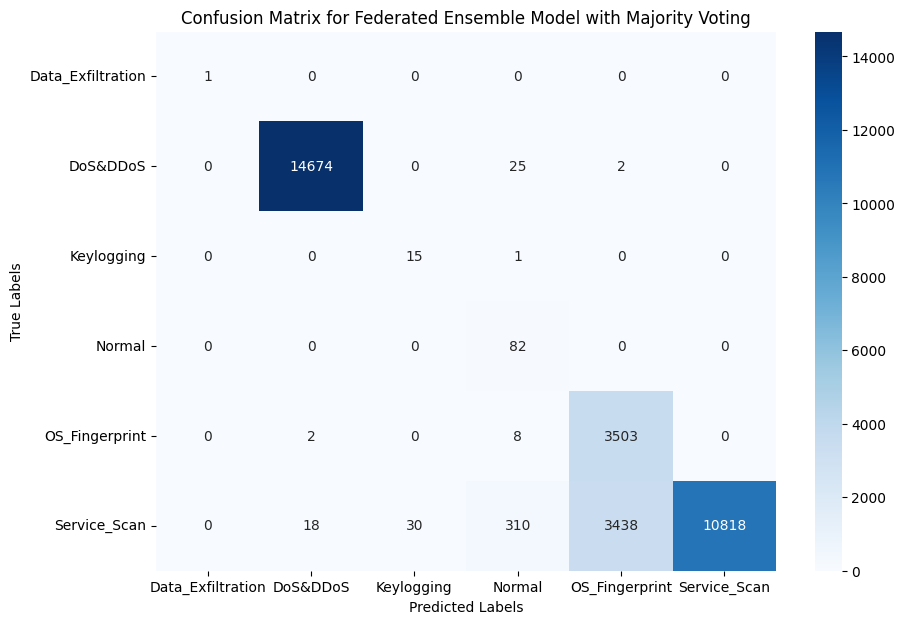

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the models for each client
client_models = []
num_classes = len(le.classes_)  # Total number of classes

for i in range(num_clients):
    unique_classes = np.unique(y_train_clients_smote[i])
    print(f"\nTraining models for Client {i + 1} with unique labels {unique_classes}")

    # Initialize the models with the total number of classes for XGBoost
    dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
    gb_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50)
    ada_model = AdaBoostClassifier(learning_rate=0.01, n_estimators=50)

    # Train non-XGBoost models
    dt_model.fit(X_train_clients_smote[i], y_train_clients_smote[i])
    gb_model.fit(X_train_clients_smote[i], y_train_clients_smote[i])
    ada_model.fit(X_train_clients_smote[i], y_train_clients_smote[i])

    # Train XGBoost only if the client has all classes
    if set(range(num_classes)).issubset(unique_classes):
        xgb_model = XGBClassifier(n_estimators=100, max_depth=5, random_state=42,
                                  num_class=num_classes, objective="multi:softmax")
        xgb_model.fit(X_train_clients_smote[i], y_train_clients_smote[i])
        client_models.append([dt_model, xgb_model, gb_model, ada_model])
    else:
        print(f"Skipping XGBoost for Client {i + 1} due to missing classes.")
        client_models.append([dt_model, None, gb_model, ada_model])

print("\nTraining completed for all clients.")

# Aggregating predictions from each client using majority voting
final_predictions = []
client_predictions = []

# Gathering predictions from each client
for i in range(num_clients):
    print(f"\nGathering predictions from Client {i + 1}...")
    dt_pred = client_models[i][0].predict(X_test)
    gb_pred = client_models[i][2].predict(X_test)
    ada_pred = client_models[i][3].predict(X_test)

    # Only predict with XGBoost if it was trained
    if client_models[i][1] is not None:
        xgb_pred = client_models[i][1].predict(X_test)
        client_predictions.append([dt_pred, xgb_pred, gb_pred, ada_pred])
    else:
        client_predictions.append([dt_pred, gb_pred, ada_pred])

# Majority voting
for k in range(len(X_test)):
    instance_votes = []
    for i in range(num_clients):
        instance_votes.extend(client_predictions[i][j][k] for j in range(len(client_predictions[i])))

    # Take the majority vote for the current instance
    final_prediction = np.bincount(instance_votes).argmax()
    final_predictions.append(final_prediction)

# Convert final predictions back to string labels for evaluation
final_predictions_str = le.inverse_transform(final_predictions)

# Evaluate the aggregated predictions
print("\nClassification Report for Federated Ensemble Model with Majority Voting:")
print(classification_report(y_test, final_predictions_str, target_names=le.classes_))

# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, final_predictions_str)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for Federated Ensemble Model with Majority Voting")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# Debugging Step: Print dimensions of X and y for each client
for i in range(num_clients):
    print(f"Client {i + 1} - X_train shape: {X_train_clients_smote[i].shape}, y_train shape: {y_train_clients_encoded[i].shape}")

# Then proceed with the training
for i in range(num_clients):
    print(f"\nTraining models for Client {i + 1} with unique labels {unique_labels[i]}")

    # Check that X and y are of the same length before fitting
    if len(X_train_clients_smote[i]) == len(y_train_clients_encoded[i]):
        dt_model.fit(X_train_clients_smote[i], y_train_clients_encoded[i])
        gb_model.fit(X_train_clients_smote[i], y_train_clients_encoded[i])
        ada_model.fit(X_train_clients_smote[i], y_train_clients_encoded[i])
    else:
        print(f"Error: Mismatch in length for Client {i + 1}")

Client 1 - X_train shape: (187380, 10), y_train shape: (70210,)
Client 2 - X_train shape: (164526, 10), y_train shape: (70210,)
Client 3 - X_train shape: (149364, 10), y_train shape: (70210,)
Client 4 - X_train shape: (76238, 10), y_train shape: (70209,)
Client 5 - X_train shape: (88278, 10), y_train shape: (70209,)

Training models for Client 1 with unique labels 0
Error: Mismatch in length for Client 1

Training models for Client 2 with unique labels 1
Error: Mismatch in length for Client 2

Training models for Client 3 with unique labels 2
Error: Mismatch in length for Client 3

Training models for Client 4 with unique labels 3
Error: Mismatch in length for Client 4

Training models for Client 5 with unique labels 4
Error: Mismatch in length for Client 5


In [ ]:
# Apply SMOTE to balance each client's data individually
X_train_clients_smote = []
y_train_clients_smote = []

for i in range(num_clients):
    min_class_size = min(Counter(y_train_clients[i]).values())
    n_neighbors = min(3, max(min_class_size - 1, 1))  # Adjust n_neighbors

    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=n_neighbors)

    # Perform SMOTE and ensure both X and y are updated
    X_smote, y_smote = smote.fit_resample(X_train_clients[i], y_train_clients[i])
    y_smote_encoded = le.transform(y_smote)  # Encode the labels after SMOTE

    # Append the balanced data
    X_train_clients_smote.append(X_smote)
    y_train_clients_smote.append(y_smote_encoded)  # Use encoded labels here

    print(f"Client {i + 1} - After SMOTE: X shape {X_smote.shape}, y shape {y_smote_encoded.shape}")

Client 1 - After SMOTE: X shape (187380, 10), y shape (187380,)
Client 2 - After SMOTE: X shape (164526, 10), y shape (164526,)
Client 3 - After SMOTE: X shape (149364, 10), y shape (149364,)
Client 4 - After SMOTE: X shape (76238, 10), y shape (76238,)
Client 5 - After SMOTE: X shape (88278, 10), y shape (88278,)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Initialize models for each client
client_models = []

for i in range(num_clients):
    unique_classes = np.unique(y_train_clients_smote[i])
    print(f"\nTraining models for Client {i + 1} with unique labels {unique_classes}")

    # Initialize the models
    dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
    gb_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50)
    ada_model = AdaBoostClassifier(learning_rate=0.01, n_estimators=50)

    # Train non-XGBoost models
    dt_model.fit(X_train_clients_smote[i], y_train_clients_smote[i])
    gb_model.fit(X_train_clients_smote[i], y_train_clients_smote[i])
    ada_model.fit(X_train_clients_smote[i], y_train_clients_smote[i])

    # Train XGBoost only if the client has all classes (for multiclass)
    if set(range(num_classes)).issubset(unique_classes):
        xgb_model = XGBClassifier(n_estimators=100, max_depth=5, random_state=42,
                                  num_class=num_classes, objective="multi:softmax")
        xgb_model.fit(X_train_clients_smote[i], y_train_clients_smote[i])
        client_models.append([dt_model, xgb_model, gb_model, ada_model])
    else:
        print(f"Skipping XGBoost for Client {i + 1} due to missing classes.")
        client_models.append([dt_model, None, gb_model, ada_model])

print("\nTraining completed for all clients.")


Training models for Client 1 with unique labels [0 1 2 3 4 5]

Training models for Client 2 with unique labels [0 1 2 3 4 5]

Training models for Client 3 with unique labels [0 1 2]
Skipping XGBoost for Client 3 due to missing classes.

Training models for Client 4 with unique labels [2 3]
Skipping XGBoost for Client 4 due to missing classes.

Training models for Client 5 with unique labels [3 4]
Skipping XGBoost for Client 5 due to missing classes.

Training completed for all clients.



Gathering predictions from Client 1...

Gathering predictions from Client 2...

Gathering predictions from Client 3...

Gathering predictions from Client 4...

Gathering predictions from Client 5...

Classification Report for Federated Ensemble Model:
                   precision    recall  f1-score   support

Data_Exfiltration       1.00      1.00      1.00         1
         DoS&DDoS       1.00      1.00      1.00     14701
       Keylogging       0.33      0.94      0.49        16
           Normal       0.19      1.00      0.32        82
   OS_Fingerprint       0.50      1.00      0.67      3513
     Service_Scan       1.00      0.74      0.85     14614

         accuracy                           0.88     32927
        macro avg       0.67      0.95      0.72     32927
     weighted avg       0.94      0.88      0.90     32927



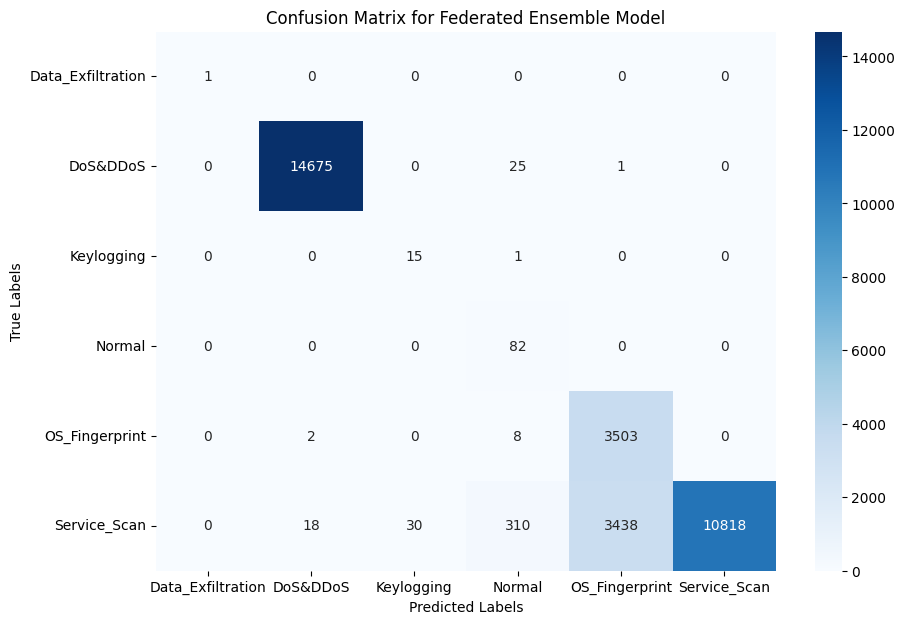

In [ ]:
# Prepare to store predictions for each test sample
client_predictions = []

for i in range(num_clients):
    print(f"\nGathering predictions from Client {i + 1}...")

    # Predict using each model on the test data and store as integers
    dt_pred = client_models[i][0].predict(X_test)
    gb_pred = client_models[i][2].predict(X_test)
    ada_pred = client_models[i][3].predict(X_test)

    if client_models[i][1] is not None:  # Only if XGBoost was trained
        xgb_pred = client_models[i][1].predict(X_test)
        client_predictions.append([dt_pred, xgb_pred, gb_pred, ada_pred])
    else:
        client_predictions.append([dt_pred, gb_pred, ada_pred])

# Aggregating predictions through majority voting
final_predictions = []
for j in range(len(X_test)):
    instance_votes = [client_predictions[i][k][j] for i in range(num_clients) for k in range(len(client_predictions[i]))]
    final_prediction = np.bincount(instance_votes).argmax()
    final_predictions.append(final_prediction)

# Convert final predictions to string labels
final_predictions_str = le.inverse_transform(final_predictions)

# Evaluate and display results
print("\nClassification Report for Federated Ensemble Model:")
print(classification_report(y_test, final_predictions_str, target_names=le.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, final_predictions_str)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for Federated Ensemble Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
!pip install xgboost

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [ ]:
num_clients = 5  # Number of clients
X_train_clients_smote = [...]  # List of SMOTE-processed data for each client
y_train_clients_encoded = [...]  # Encoded labels for each client
X_test = [...]  # Test dataset
y_test = [...]  # Encoded labels for the test dataset

In [ ]:
print(X_train_clients_smote)
print(y_train_clients_encoded)

[Ellipsis]
[Ellipsis]


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X_train_clients_smote = []
y_train_clients_encoded = []

for i in range(num_clients):
    # Determine the minimum class size for the current client's data
    min_class_size = min(Counter(y_train_clients[i]).values())
    n_neighbors = min(3, min_class_size - 1)  # Ensure n_neighbors <= min_class_size - 1

    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=n_neighbors)
    X_smote, y_smote = smote.fit_resample(X_train_clients[i], y_train_clients[i])
    y_smote_encoded = le.transform(y_smote)  # Assuming `le` is your LabelEncoder

    X_train_clients_smote.append(X_smote)
    y_train_clients_encoded.append(y_smote_encoded)

# Print shapes to verify the result
for i in range(num_clients):
    print(f"Client {i + 1} - After SMOTE: X shape {X_train_clients_smote[i].shape}, y shape {y_train_clients_encoded[i].shape}")

Client 1 - After SMOTE: X shape (187380, 10), y shape (187380,)
Client 2 - After SMOTE: X shape (164526, 10), y shape (164526,)
Client 3 - After SMOTE: X shape (149364, 10), y shape (149364,)
Client 4 - After SMOTE: X shape (76238, 10), y shape (76238,)
Client 5 - After SMOTE: X shape (88278, 10), y shape (88278,)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

client_models = []

for i in range(num_clients):
    print(f"\nTraining Stacking model for Client {i + 1}...")

    # Define the base models
    base_estimators = [
        ('dt', DecisionTreeClassifier(max_depth=10, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=42))
    ]

    # Define the stacking model with XGBoost as the meta-learner
    stacking_model = StackingClassifier(
        estimators=base_estimators,
        final_estimator=XGBClassifier(n_estimators=100, max_depth=5, random_state=42, use_label_encoder=False)
    )

    # Train the stacking model on each client's data
    stacking_model.fit(X_train_clients_smote[i], y_train_clients_encoded[i])

    # Append the trained model to the list for each client
    client_models.append(stacking_model)

print("\nTraining completed for all clients.")


Training Stacking model for Client 1...

Training Stacking model for Client 2...

Training Stacking model for Client 3...

Training Stacking model for Client 4...

Training Stacking model for Client 5...

Training completed for all clients.


In [ ]:
print(X_test[:5])  # Check the first few rows
print(y_test[:5])

[Ellipsis]
[Ellipsis]


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your full dataset features and labels respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Gathering predictions from Client 1...
Gathering predictions from Client 2...
Gathering predictions from Client 3...
Gathering predictions from Client 4...
Gathering predictions from Client 5...

Classification Report for Federated Ensemble Model with Stacking and Majority Voting:
                   precision    recall  f1-score   support

Data_Exfiltration       0.50      1.00      0.67         1
         DoS&DDoS       1.00      1.00      1.00     14701
       Keylogging       1.00      0.88      0.93        16
           Normal       0.67      0.99      0.80        82
   OS_Fingerprint       0.62      0.99      0.76      3513
     Service_Scan       1.00      0.85      0.92     14614

         accuracy                           0.93     32927
        macro avg       0.80      0.95      0.85     32927
     weighted avg       0.96      0.93      0.94     32927



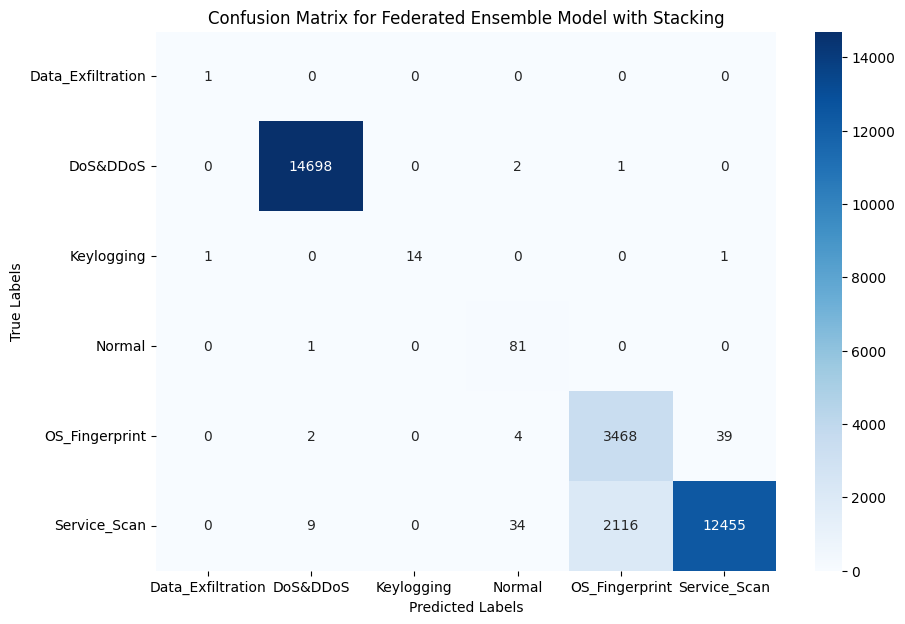

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Prepare to store predictions from each client
client_predictions = []

# Step 1: Gather predictions from each client model
for i in range(num_clients):
    print(f"Gathering predictions from Client {i + 1}...")
    client_pred = client_models[i].predict(X_test)  # Predictions for this client
    client_predictions.append(client_pred)

# Step 2: Aggregating predictions (Majority Voting)
final_predictions = []
for j in range(len(X_test)):
    # Collect predictions from each client for the j-th instance
    instance_votes = [client_predictions[i][j] for i in range(num_clients)]
    # Find the majority class label for the instance
    final_prediction = np.bincount(instance_votes).argmax()
    final_predictions.append(final_prediction)

# Step 3: Convert final_predictions to original labels if encoded
final_predictions_str = le.inverse_transform(final_predictions)

# Step 4: Evaluate the final federated model
print("\nClassification Report for Federated Ensemble Model with Stacking and Majority Voting:")
print(classification_report(y_test, final_predictions_str, target_names=le.classes_))

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, final_predictions_str)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for Federated Ensemble Model with Stacking")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Classification Report for Hybrid Model (DT-CART + XGBoost + LR meta-learner):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00     14489
           2       1.00      1.00      1.00        12
           3       0.99      0.99      0.99        77
           4       0.83      0.98      0.90      3634
           5       0.99      0.95      0.97     14713

    accuracy                           0.98     32927
   macro avg       0.97      0.99      0.98     32927
weighted avg       0.98      0.98      0.98     32927

Training Time: 14.53 seconds
Prediction Time: 0.10 seconds


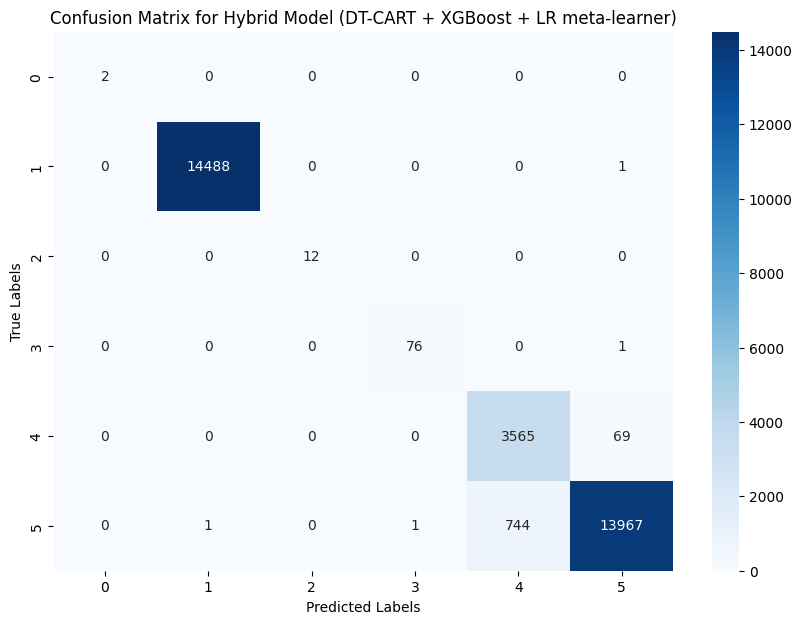

In [ ]:
import time
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define base models
cart_model = DecisionTreeClassifier(random_state=42, max_depth=10)
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, random_state=42, objective="multi:softmax")
meta_learner = LogisticRegression(max_iter=1000, random_state=42)

# Measure training time
start_time = time.time()

# Train base models and meta-learner
cart_model.fit(X_Smote_Train, Y_Smote_Train)
X_train_cart_pred = pd.DataFrame(cart_model.predict(X_Smote_Train), columns=["Cart_Pred"])

# Concatenate original features with CART predictions
X_train_hybrid = pd.concat([pd.DataFrame(X_Smote_Train), X_train_cart_pred], axis=1)

# Train XGBoost on the hybrid feature set
xgb_model.fit(X_train_hybrid, Y_Smote_Train)
X_train_xgb_pred = pd.DataFrame(xgb_model.predict(X_train_hybrid), columns=["XGB_Pred"])

# Train the meta-learner on XGBoost predictions
meta_learner.fit(X_train_xgb_pred, Y_Smote_Train)

training_time = time.time() - start_time

# Measure prediction time
start_time = time.time()

# Predictions on the test set
X_test_cart_pred = pd.DataFrame(cart_model.predict(X_Test), columns=["Cart_Pred"])
X_test_hybrid = pd.concat([pd.DataFrame(X_Test), X_test_cart_pred], axis=1)
X_test_xgb_pred = pd.DataFrame(xgb_model.predict(X_test_hybrid), columns=["XGB_Pred"])
y_pred_hybrid = meta_learner.predict(X_test_xgb_pred)

prediction_time = time.time() - start_time

# Evaluation
print("Classification Report for Hybrid Model (DT-CART + XGBoost + LR meta-learner):")
print(classification_report(Y_Test, y_pred_hybrid))
print(f"Training Time: {training_time:.2f} seconds")
print(f"Prediction Time: {prediction_time:.2f} seconds")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_Test, y_pred_hybrid)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Hybrid Model (DT-CART + XGBoost + LR meta-learner)")
plt.show()

Classification Report for Hybrid Model (DT-CART + XGBoost + LR meta-learner):
                   precision    recall  f1-score   support

Data_Exfiltration       1.00      1.00      1.00         2
         DoS&DDoS       1.00      1.00      1.00     14489
       Keylogging       1.00      1.00      1.00        12
           Normal       0.99      0.99      0.99        77
OS_Fingerprinting       0.83      0.98      0.90      3634
     Service_Scan       0.99      0.95      0.97     14713

         accuracy                           0.98     32927
        macro avg       0.97      0.99      0.98     32927
     weighted avg       0.98      0.98      0.98     32927

Training Time: 14.53 seconds
Prediction Time: 0.10 seconds


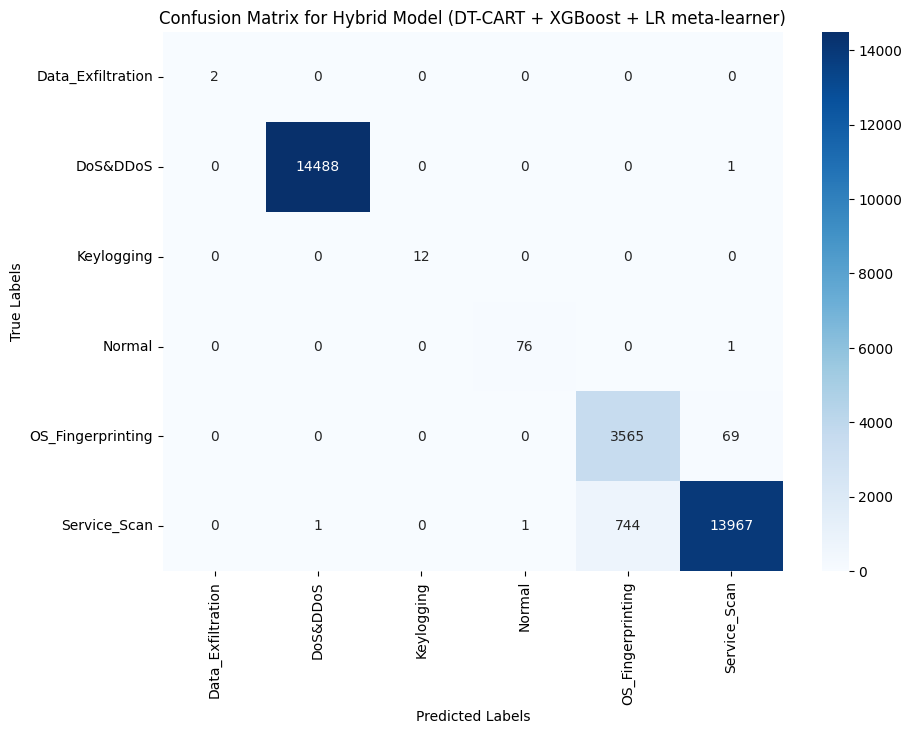

In [ ]:
# Define class names
class_names = ["Data_Exfiltration", "DoS&DDoS", "Keylogging", "Normal", "OS_Fingerprinting", "Service_Scan"]

# Generate and print classification report with class names
print("Classification Report for Hybrid Model (DT-CART + XGBoost + LR meta-learner):")
print(classification_report(Y_Test, y_pred_hybrid, target_names=class_names))
print(f"Training Time: {training_time:.2f} seconds")
print(f"Prediction Time: {prediction_time:.2f} seconds")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_Test, y_pred_hybrid)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Hybrid Model (DT-CART + XGBoost + LR meta-learner)")
plt.show()

Classification Report for Stacking Ensemble (XGBoost, RF, DT, LR meta-learner):
                   precision    recall  f1-score   support

Data_Exfiltration       1.00      1.00      1.00         2
         DoS&DDoS       1.00      1.00      1.00     14489
       Keylogging       1.00      1.00      1.00        12
           Normal       1.00      1.00      1.00        77
OS_Fingerprinting       0.83      0.97      0.90      3634
     Service_Scan       0.99      0.95      0.97     14713

         accuracy                           0.98     32927
        macro avg       0.97      0.99      0.98     32927
     weighted avg       0.98      0.98      0.98     32927

Training Time: 239.52 seconds
Prediction Time: 0.22 seconds


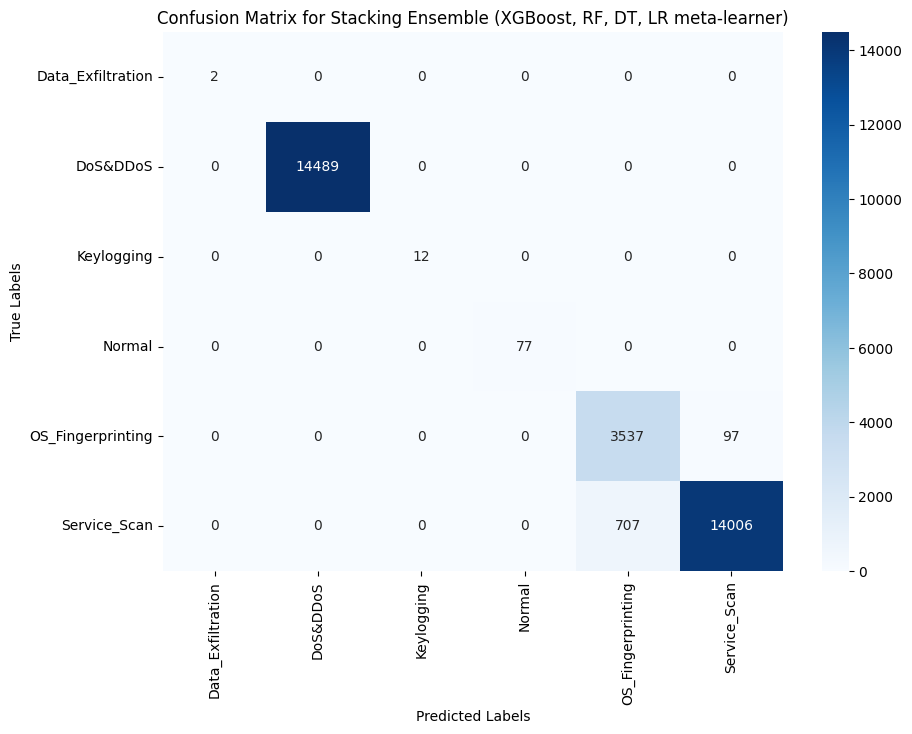

In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define class names
class_names = ["Data_Exfiltration", "DoS&DDoS", "Keylogging", "Normal", "OS_Fingerprinting", "Service_Scan"]

# Define base models
base_models = [
    ('xgb', XGBClassifier(n_estimators=100, max_depth=5, random_state=42, objective="multi:softmax")),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42, max_depth=10))
]

# Define meta-learner
meta_learner = LogisticRegression(max_iter=1000, random_state=42)

# Create the stacking ensemble
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_learner, stack_method='predict_proba')

# Measure training time
start_time = time.time()
stacking_model.fit(X_Smote_Train, Y_Smote_Train)
training_time = time.time() - start_time

# Measure prediction time
start_time = time.time()
y_pred_stacking = stacking_model.predict(X_Test)
prediction_time = time.time() - start_time

# Evaluation
print("Classification Report for Stacking Ensemble (XGBoost, RF, DT, LR meta-learner):")
print(classification_report(Y_Test, y_pred_stacking, target_names=class_names))
print(f"Training Time: {training_time:.2f} seconds")
print(f"Prediction Time: {prediction_time:.2f} seconds")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_Test, y_pred_stacking)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Stacking Ensemble (XGBoost, RF, DT, LR meta-learner)")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Define cross-validation function for Hybrid Model
def cross_val_hybrid_model(X, Y, cv=5):
    cart_model = DecisionTreeClassifier(random_state=42, max_depth=10)
    xgb_model = XGBClassifier(n_estimators=100, max_depth=5, random_state=42, objective="multi:softmax")
    meta_learner = LogisticRegression(max_iter=1000, random_state=42)

    # Generate CART predictions as additional features for XGBoost
    cart_model.fit(X, Y)
    X_cart_pred = pd.DataFrame(cart_model.predict(X), columns=["Cart_Pred"])
    X_hybrid = pd.concat([pd.DataFrame(X), X_cart_pred], axis=1)

    # Generate XGBoost predictions to be used by the meta-learner
    xgb_model.fit(X_hybrid, Y)
    X_xgb_pred = pd.DataFrame(xgb_model.predict(X_hybrid), columns=["XGB_Pred"])

    # Cross-validation on meta-learner using XGBoost predictions
    scores = cross_val_score(meta_learner, X_xgb_pred, Y, cv=cv, scoring="accuracy")
    print("Cross-Validation Scores for Hybrid Model (DT-CART + XGBoost + LR meta-learner):", scores)
    print("Mean CV Accuracy for Hybrid Model:", np.mean(scores))

# Run cross-validation for Hybrid Model
cross_val_hybrid_model(X_Smote_Train, Y_Smote_Train)

Cross-Validation Scores for Hybrid Model (DT-CART + XGBoost + LR meta-learner): [0.98865833 0.98992325 0.99019329 0.98952515 0.98963885]
Mean CV Accuracy for Hybrid Model: 0.9895877747697606


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Define the stacking ensemble model
base_models = [
    ('xgb', XGBClassifier(n_estimators=100, max_depth=5, random_state=42, objective="multi:softmax")),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42, max_depth=10))
]
meta_learner = LogisticRegression(max_iter=1000, random_state=42)
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_learner, stack_method='predict_proba')

# Run cross-validation for Stacking Ensemble
cv_scores = cross_val_score(stacking_model, X_Smote_Train, Y_Smote_Train, cv=5, scoring="accuracy")
print("Cross-Validation Scores for Stacking Ensemble (XGBoost, RF, DT, LR meta-learner):", cv_scores)
print("Mean CV Accuracy for Stacking Ensemble:", np.mean(cv_scores))

Cross-Validation Scores for Stacking Ensemble (XGBoost, RF, DT, LR meta-learner): [0.98787663 0.98897101 0.9891842  0.98841655 0.98867238]
Mean CV Accuracy for Stacking Ensemble: 0.9886241531805846


In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define class labels
class_names = ['Data_Exfiltration', 'DoS&DDoS', 'Keylogging', 'Normal', 'OS_Fingerprint', 'Service_Scan']

# Initialize models with reduced parameters to avoid long training time
dt_model = DecisionTreeClassifier(random_state=42, max_depth=3)  # Reduced depth
gb_model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=5)  # Fewer estimators and lower learning rate
ada_model = AdaBoostClassifier(n_estimators=10)  # Fewer estimators
rf_model = RandomForestClassifier(n_estimators=10, random_state=42)

# Train each model
start_train = time.time()
dt_model.fit(X_Train, Y_Train)
gb_model.fit(X_Train, Y_Train)
ada_model.fit(X_Train, Y_Train)
rf_model.fit(X_Train, Y_Train)
train_time = time.time() - start_train

# Make predictions on each model
start_test = time.time()
pred_dt = dt_model.predict(X_Test)
pred_gb = gb_model.predict(X_Test)
pred_ada = ada_model.predict(X_Test)
pred_rf = rf_model.predict(X_Test)
test_time = time.time() - start_test

# Majority Voting
final_predictions = []
for i in range(len(X_Test)):
    votes = [pred_dt[i], pred_gb[i], pred_ada[i], pred_rf[i]]
    final_prediction = max(set(votes), key=votes.count)  # Take the majority vote
    final_predictions.append(final_prediction)

# Evaluate the aggregated model
print("\nMajority Voting Federated Ensemble Classifier Report:")
print(classification_report(Y_Test, final_predictions, target_names=class_names, digits=3))
print(f"Total Training Time: {train_time:.2f}s, Total Prediction Time: {test_time:.2f}s")

# Confusion Matrix
cm_ensemble = confusion_matrix(Y_Test, final_predictions)
print("\nConfusion Matrix for Majority Voting Federated Ensemble:")
print(cm_ensemble)


Majority Voting Federated Ensemble Classifier Report:
                   precision    recall  f1-score   support

Data_Exfiltration      1.000     1.000     1.000         2
         DoS&DDoS      0.998     0.984     0.991     14489
       Keylogging      1.000     1.000     1.000        12
           Normal      0.961     0.636     0.766        77
   OS_Fingerprint      0.889     0.614     0.726      3634
     Service_Scan      0.897     0.980     0.937     14713

         accuracy                          0.940     32927
        macro avg      0.957     0.869     0.903     32927
     weighted avg      0.941     0.940     0.937     32927

Total Training Time: 10.60s, Total Prediction Time: 0.07s

Confusion Matrix for Majority Voting Federated Ensemble:
[[    2     0     0     0     0     0]
 [    0 14255     0     0     0   234]
 [    0     0    12     0     0     0]
 [    0     1     0    49     0    27]
 [    0    13     0     1  2232  1388]
 [    0    16     0     1   280 14416]]


In [ ]:
# Define features (X) and target (y) from train_data
X = train_data.drop(columns=['subcategory'])  # Replace 'subcategory' with the actual target column name if different
y = train_data['subcategory']

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming you have your features and target defined as X and y
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(len(X), len(y))

2934649 2934649


In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define class labels
class_names = ['Data_Exfiltration', 'DoS&DDoS', 'Keylogging', 'Normal', 'OS_Fingerprint', 'Service_Scan']

# Initialize base models with reduced parameters to avoid long training times
dt_model = DecisionTreeClassifier(random_state=42, max_depth=3)  # Reduced depth
gb_model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=5, random_state=42)  # Fewer estimators and lower learning rate
ada_model = AdaBoostClassifier(n_estimators=5, random_state=42)  # Fewer estimators
meta_model = LogisticRegression(max_iter=100)  # Meta-classifier for stacking

# Train each base model
start_train = time.time()
dt_model.fit(X_Train, Y_Train)
gb_model.fit(X_Train, Y_Train)
ada_model.fit(X_Train, Y_Train)
train_time = time.time() - start_train

# Make predictions on each model for majority voting
start_test = time.time()
pred_dt = dt_model.predict(X_Test)
pred_gb = gb_model.predict(X_Test)
pred_ada = ada_model.predict(X_Test)
test_time = time.time() - start_test

# Majority Voting
final_predictions = []
for i in range(len(X_Test)):
    votes = [pred_dt[i], pred_gb[i], pred_ada[i]]
    final_prediction = max(set(votes), key=votes.count)  # Take the majority vote
    final_predictions.append(final_prediction)

# Evaluate the Majority Voting Ensemble
print("\nMajority Voting Federated Ensemble Classifier Report:")
print(classification_report(Y_Test, final_predictions, target_names=class_names, digits=3))
print(f"Total Training Time: {train_time:.2f}s, Total Prediction Time: {test_time:.2f}s")

# Confusion Matrix for Majority Voting Ensemble
cm_ensemble = confusion_matrix(Y_Test, final_predictions)
print("\nConfusion Matrix for Majority Voting Federated Ensemble:")
print(cm_ensemble)

# Stacking with Meta Model
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('dt', dt_model),
        ('gb', gb_model),
        ('ada', ada_model)
    ],
    final_estimator=meta_model,
    cv=5
)

# Train and evaluate the Stacking Classifier
start_train = time.time()
stacking_clf.fit(X_Train, Y_Train)
train_time_stacking = time.time() - start_train

start_test = time.time()
y_pred_stacking = stacking_clf.predict(X_Test)
test_time_stacking = time.time() - start_test

# Evaluate Stacking Classifier
print("\nStacking Federated Ensemble Classifier Report:")
print(classification_report(Y_Test, y_pred_stacking, target_names=class_names, digits=3))
print(f"Total Training Time (Stacking): {train_time_stacking:.2f}s, Total Prediction Time (Stacking): {test_time_stacking:.2f}s")

# Confusion Matrix for Stacking Classifier
cm_stacking = confusion_matrix(Y_Test, y_pred_stacking)
print("\nConfusion Matrix for Stacking Federated Ensemble:")
print(cm_stacking)


Majority Voting Federated Ensemble Classifier Report:
                   precision    recall  f1-score   support

Data_Exfiltration      0.000     0.000     0.000         2
         DoS&DDoS      0.992     0.979     0.986     14489
       Keylogging      0.000     0.000     0.000        12
           Normal      0.953     0.532     0.683        77
   OS_Fingerprint      0.000     0.000     0.000      3634
     Service_Scan      0.790     0.998     0.882     14713

         accuracy                          0.878     32927
        macro avg      0.456     0.418     0.425     32927
     weighted avg      0.792     0.878     0.830     32927

Total Training Time: 8.26s, Total Prediction Time: 0.04s

Confusion Matrix for Majority Voting Federated Ensemble:
[[    0     0     0     0     0     2]
 [    0 14186     0     0     0   303]
 [    0     0     0     0     0    12]
 [    0     3     0    41     0    33]
 [    0    82     0     1     0  3551]
 [    0    23     0     1     0 14689]]

S

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import time

# Define class names based on your specific dataset labels
class_names = ['Data_Exfiltration', 'DoS&DDoS', 'Keylogging', 'Normal', 'OS_Fingerprint', 'Service_Scan']

# Define number of clients for federated setup
num_clients = 3
X_train_clients = np.array_split(X_Train, num_clients)
y_train_clients = np.array_split(Y_Train, num_clients)

# Initialize client models list
client_models = []

# Train models for each client
for i in range(num_clients):
    print(f"Training models for Client {i + 1}...")

    # Base models for stacking
    dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
    gb_model = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, random_state=42)
    ada_model = AdaBoostClassifier(n_estimators=10, random_state=42)

    # Stacking model
    stack_model = StackingClassifier(
        estimators=[('dt', dt_model), ('gb', gb_model), ('ada', ada_model)],
        final_estimator=LogisticRegression(),
        cv=3
    )

    # Train and store the model for each client
    stack_model.fit(X_train_clients[i], y_train_clients[i])
    client_models.append(stack_model)

# Aggregate predictions with Majority Voting
final_predictions = []
for j in range(len(X_Test)):
    instance_votes = []
    for client in client_models:
        pred = client.predict(X_Test[j].reshape(1, -1))[0]
        instance_votes.append(pred)

    # Majority voting
    final_prediction = max(set(instance_votes), key=instance_votes.count)
    final_predictions.append(final_prediction)

# Evaluation
print("\nFederated Ensemble with Stacking and Majority Voting — Classifier Report:")
print(classification_report(Y_Test, final_predictions, target_names=class_names))
print(f"Accuracy: {accuracy_score(Y_Test, final_predictions):.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_Test, final_predictions)
print("\nConfusion Matrix for Federated Ensemble with Stacking and Majority Voting:")
print(conf_matrix)

Training models for Client 1...
Training models for Client 2...
Training models for Client 3...

Federated Ensemble with Stacking and Majority Voting — Classifier Report:
                   precision    recall  f1-score   support

Data_Exfiltration       0.00      0.00      0.00         2
         DoS&DDoS       1.00      1.00      1.00     14489
       Keylogging       0.86      1.00      0.92        12
           Normal       0.90      0.58      0.71        77
   OS_Fingerprint       0.62      0.44      0.51      3634
     Service_Scan       0.87      0.93      0.90     14713

         accuracy                           0.91     32927
        macro avg       0.71      0.66      0.67     32927
     weighted avg       0.90      0.91      0.90     32927

Accuracy: 0.91

Confusion Matrix for Federated Ensemble with Stacking and Majority Voting:
[[    0     0     2     0     0     0]
 [    0 14487     0     2     0     0]
 [    0     0    12     0     0     0]
 [    0     0     0    45   

In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import time
from collections import Counter

# Define class names based on your specific dataset labels
class_names = ['Data_Exfiltration', 'DoS&DDoS', 'Keylogging', 'Normal', 'OS_Fingerprint', 'Service_Scan']

# Define number of clients for federated setup
num_clients = 3
X_train_clients = np.array_split(X_Train, num_clients)
y_train_clients = np.array_split(Y_Train, num_clients)

# Initialize client models list
client_models = []

# Train models for each client with conditional SMOTE application
for i in range(num_clients):
    print(f"\nApplying SMOTE and training models for Client {i + 1}...")

    # Check class distribution for each client
    class_counts = Counter(y_train_clients[i])
    print(f"Class distribution for Client {i + 1}: {class_counts}")

    # Decide whether to use SMOTE or Random Oversampling
    apply_smote = all(count >= 2 for count in class_counts.values())  # SMOTE requires at least 2 samples per class

    if apply_smote:
        print("Using SMOTE for balancing...")
        sampler = SMOTE(random_state=42, k_neighbors=1)
    else:
        print("Using Random Oversampling for balancing...")
        sampler = RandomOverSampler(random_state=42)

    # Apply the chosen sampler to balance each client's data
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_clients[i], y_train_clients[i])

    # Base models for stacking
    dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
    gb_model = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, random_state=42)
    ada_model = AdaBoostClassifier(n_estimators=10, random_state=42)

    # Stacking model
    stack_model = StackingClassifier(
        estimators=[('dt', dt_model), ('gb', gb_model), ('ada', ada_model)],
        final_estimator=LogisticRegression(),
        cv=3
    )

    # Train and store the model for each client
    stack_model.fit(X_train_resampled, y_train_resampled)
    client_models.append(stack_model)

# Aggregate predictions with Majority Voting
final_predictions = []
for j in range(len(X_Test)):
    instance_votes = []
    for client in client_models:
        pred = client.predict(X_Test[j].reshape(1, -1))[0]
        instance_votes.append(pred)

    # Majority voting
    final_prediction = max(set(instance_votes), key=instance_votes.count)
    final_predictions.append(final_prediction)

# Evaluation
print("\nFederated Ensemble with SMOTE (or Random Oversampling), Stacking, and Majority Voting — Classifier Report:")
print(classification_report(Y_Test, final_predictions, target_names=class_names))
print(f"Accuracy: {accuracy_score(Y_Test, final_predictions):.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_Test, final_predictions)
print("\nConfusion Matrix for Federated Ensemble with SMOTE (or Random Oversampling), Stacking, and Majority Voting:")
print(conf_matrix)


Applying SMOTE and training models for Client 1...
Class distribution for Client 1: Counter({1: 19608, 5: 19325, 4: 4811, 3: 140, 2: 16, 0: 2})
Using SMOTE for balancing...

Applying SMOTE and training models for Client 2...
Class distribution for Client 2: Counter({5: 19702, 1: 19437, 4: 4626, 3: 114, 2: 21, 0: 1})
Using Random Oversampling for balancing...

Applying SMOTE and training models for Client 3...
Class distribution for Client 3: Counter({1: 19588, 5: 19382, 4: 4811, 3: 99, 2: 21})
Using SMOTE for balancing...

Federated Ensemble with SMOTE (or Random Oversampling), Stacking, and Majority Voting — Classifier Report:
                   precision    recall  f1-score   support

Data_Exfiltration       1.00      1.00      1.00         2
         DoS&DDoS       1.00      0.97      0.98     14489
       Keylogging       0.39      1.00      0.56        12
           Normal       0.36      0.99      0.52        77
   OS_Fingerprint       0.42      0.94      0.58      3634
     Ser

In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import time
from collections import Counter

# Define class names based on your specific dataset labels
class_names = ['Data_Exfiltration', 'DoS&DDoS', 'Keylogging', 'Normal', 'OS_Fingerprint', 'Service_Scan']

# Split the dataset into clients (for federated learning)
num_clients = 3
X_train_clients = np.array_split(X_Train, num_clients)
y_train_clients = np.array_split(Y_Train, num_clients)

# Initialize client models list
client_models = []

# Federated Learning - Train models locally on each client with conditional SMOTE or Random Oversampling
for i in range(num_clients):
    print(f"\nTraining model for Client {i + 1}...")

    # Check class distribution for each client
    class_counts = Counter(y_train_clients[i])
    print(f"Class distribution for Client {i + 1}: {class_counts}")

    # Decide whether to use SMOTE or Random Oversampling
    apply_smote = all(count >= 2 for count in class_counts.values())  # SMOTE requires at least 2 samples per class

    if apply_smote:
        print("Using SMOTE for balancing...")
        sampler = SMOTE(random_state=42, k_neighbors=1)
    else:
        print("Using Random Oversampling for balancing...")
        sampler = RandomOverSampler(random_state=42)

    # Apply the chosen sampler to balance each client's data
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_clients[i], y_train_clients[i])

    # Base models for stacking
    dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
    gb_model = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, random_state=42)
    ada_model = AdaBoostClassifier(n_estimators=10, random_state=42)

    # Stacking model
    stack_model = StackingClassifier(
        estimators=[('dt', dt_model), ('gb', gb_model), ('ada', ada_model)],
        final_estimator=LogisticRegression(),
        cv=3
    )

    # Train and store the model for each client
    stack_model.fit(X_train_resampled, y_train_resampled)
    client_models.append(stack_model)

# Aggregate predictions with Majority Voting
final_predictions = []
for j in range(len(X_Test)):
    instance_votes = []
    for client in client_models:
        pred = client.predict(X_Test[j].reshape(1, -1))[0]
        instance_votes.append(pred)

    # Majority voting for final decision
    final_prediction = max(set(instance_votes), key=instance_votes.count)
    final_predictions.append(final_prediction)

# Evaluation
print("\nFederated Learning - Classifier Report:")
print(classification_report(Y_Test, final_predictions, target_names=class_names))
print(f"Accuracy: {accuracy_score(Y_Test, final_predictions):.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_Test, final_predictions)
print("\nConfusion Matrix for Federated Learning:")
print(conf_matrix)


Training model for Client 1...
Class distribution for Client 1: Counter({1: 19608, 5: 19325, 4: 4811, 3: 140, 2: 16, 0: 2})
Using SMOTE for balancing...

Training model for Client 2...
Class distribution for Client 2: Counter({5: 19702, 1: 19437, 4: 4626, 3: 114, 2: 21, 0: 1})
Using Random Oversampling for balancing...

Training model for Client 3...
Class distribution for Client 3: Counter({1: 19588, 5: 19382, 4: 4811, 3: 99, 2: 21})
Using SMOTE for balancing...

Federated Learning - Classifier Report:
                   precision    recall  f1-score   support

Data_Exfiltration       1.00      1.00      1.00         2
         DoS&DDoS       1.00      0.97      0.98     14489
       Keylogging       0.39      1.00      0.56        12
           Normal       0.36      0.99      0.52        77
   OS_Fingerprint       0.42      0.94      0.58      3634
     Service_Scan       0.96      0.68      0.80     14713

         accuracy                           0.84     32927
        macro av

In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
from collections import Counter

# Define class labels based on your specific dataset labels
class_names = ['Data_Exfiltration', 'DoS&DDoS', 'Keylogging', 'Normal', 'OS_Fingerprint', 'Service_Scan']

# Split the dataset into clients (for federated learning)
num_clients = 3
X_train_clients = np.array_split(X_Train, num_clients)
y_train_clients = np.array_split(Y_Train, num_clients)

# Initialize lists to store models
client_models_smote = []

# ---- Federated Ensemble with Conditional SMOTE ----
print("\nTraining Federated Ensemble with Conditional SMOTE or Random Oversampling...")
for i in range(num_clients):
    print(f"\nApplying SMOTE or Random Oversampling for Client {i + 1}...")

    # Check class distribution
    class_counts = Counter(y_train_clients[i])
    apply_smote = all(count >= 2 for count in class_counts.values())  # SMOTE requires at least 2 samples per class

    if apply_smote:
        print("Using SMOTE for balancing...")
        sampler = SMOTE(random_state=42, k_neighbors=1)
    else:
        print("Using Random Oversampling for balancing...")
        sampler = RandomOverSampler(random_state=42)

    # Apply the chosen sampler
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_clients[i], y_train_clients[i])

    # Define base models
    dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
    gb_model = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, random_state=42)
    ada_model = AdaBoostClassifier(n_estimators=10, random_state=42)

    # Define stacking model
    stack_model = StackingClassifier(
        estimators=[('dt', dt_model), ('gb', gb_model), ('ada', ada_model)],
        final_estimator=LogisticRegression(),
        cv=3
    )

    # Train model with resampled data
    stack_model.fit(X_train_resampled, y_train_resampled)
    client_models_smote.append(stack_model)

# ---- Evaluation for Federated Ensemble with SMOTE ----
print("\nEvaluating Federated Ensemble with SMOTE and Majority Voting...")
final_predictions_smote = []
for j in range(len(X_Test)):
    instance_votes = []
    for model in client_models_smote:
        pred = model.predict(X_Test[j].reshape(1, -1))[0]
        instance_votes.append(pred)
    final_prediction = max(set(instance_votes), key=instance_votes.count)  # Majority voting
    final_predictions_smote.append(final_prediction)

print("\nFederated Ensemble with SMOTE (or Random Oversampling) - Classification Report:")
print(classification_report(Y_Test, final_predictions_smote, target_names=class_names))
print("Accuracy:", accuracy_score(Y_Test, final_predictions_smote))


Training Federated Ensemble with Conditional SMOTE or Random Oversampling...

Applying SMOTE or Random Oversampling for Client 1...
Using SMOTE for balancing...

Applying SMOTE or Random Oversampling for Client 2...
Using Random Oversampling for balancing...

Applying SMOTE or Random Oversampling for Client 3...
Using SMOTE for balancing...

Evaluating Federated Ensemble with SMOTE and Majority Voting...

Federated Ensemble with SMOTE (or Random Oversampling) - Classification Report:
                   precision    recall  f1-score   support

Data_Exfiltration       1.00      1.00      1.00         2
         DoS&DDoS       1.00      0.97      0.98     14489
       Keylogging       0.39      1.00      0.56        12
           Normal       0.36      0.99      0.52        77
   OS_Fingerprint       0.42      0.94      0.58      3634
     Service_Scan       0.96      0.68      0.80     14713

         accuracy                           0.84     32927
        macro avg       0.69      0.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
from collections import Counter

# Define class labels based on your specific dataset labels
class_names = ['Data_Exfiltration', 'DoS&DDoS', 'Keylogging', 'Normal', 'OS_Fingerprint', 'Service_Scan']

# Split the dataset into clients (for federated learning)
num_clients = 3
X_train_clients = np.array_split(X_Train, num_clients)
y_train_clients = np.array_split(Y_Train, num_clients)

# Initialize lists to store models
client_models_basic = []

# ---- Basic Federated Ensemble without Resampling ----
print("\nTraining Basic Federated Ensemble (No Resampling)...")
for i in range(num_clients):
    print(f"Training model for Client {i + 1} (Basic Federated Ensemble)...")

    # Define base models
    dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
    gb_model = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, random_state=42)
    ada_model = AdaBoostClassifier(n_estimators=10, random_state=42)

    # Define stacking model
    stack_model = StackingClassifier(
        estimators=[('dt', dt_model), ('gb', gb_model), ('ada', ada_model)],
        final_estimator=LogisticRegression(),
        cv=3
    )

    # Train model with client data
    stack_model.fit(X_train_clients[i], y_train_clients[i])
    client_models_basic.append(stack_model)

# ---- Evaluation for Basic Federated Ensemble ----
print("\nEvaluating Basic Federated Ensemble with Majority Voting...")
final_predictions_basic = []
for j in range(len(X_Test)):
    instance_votes = []
    for model in client_models_basic:
        pred = model.predict(X_Test[j].reshape(1, -1))[0]
        instance_votes.append(pred)
    final_prediction = max(set(instance_votes), key=instance_votes.count)  # Majority voting
    final_predictions_basic.append(final_prediction)

print("\nBasic Federated Ensemble - Classification Report:")
print(classification_report(Y_Test, final_predictions_basic, target_names=class_names))
print("Accuracy:", accuracy_score(Y_Test, final_predictions_basic))

# Confusion Matrix
conf_matrix_basic = confusion_matrix(Y_Test, final_predictions_basic)
print("\nConfusion Matrix for Basic Federated Ensemble:")
print(conf_matrix_basic)


Training Basic Federated Ensemble (No Resampling)...
Training model for Client 1 (Basic Federated Ensemble)...
Training model for Client 2 (Basic Federated Ensemble)...
Training model for Client 3 (Basic Federated Ensemble)...

Evaluating Basic Federated Ensemble with Majority Voting...

Basic Federated Ensemble - Classification Report:
                   precision    recall  f1-score   support

Data_Exfiltration       0.00      0.00      0.00         2
         DoS&DDoS       1.00      1.00      1.00     14489
       Keylogging       0.86      1.00      0.92        12
           Normal       0.92      0.58      0.71        77
   OS_Fingerprint       0.62      0.44      0.51      3634
     Service_Scan       0.87      0.93      0.90     14713

         accuracy                           0.91     32927
        macro avg       0.71      0.66      0.67     32927
     weighted avg       0.90      0.91      0.90     32927

Accuracy: 0.906399003857017

Confusion Matrix for Basic Federated E

In [ ]:
import uuid

# Assign unique identities to each client
client_ids = [str(uuid.uuid4()) for _ in range(num_clients)]
client_permissions = {client_id: True for client_id in client_ids}  # Simplified access control

# Check permissions during model training
for i in range(num_clients):
    client_id = client_ids[i]
    if not client_permissions.get(client_id, False):
        print(f"Access denied for Client {client_id}")
        continue

    print(f"Training model for Client {client_id} with ID verification...")
    # Existing training code

Training model for Client bc285b7d-4f70-4b2b-ab0c-390ba0c8b0c5 with ID verification...
Training model for Client 35b546eb-e024-4486-8fe9-8b45491afcab with ID verification...
Training model for Client 71ead2a3-5c72-47d3-b9ed-56f6caf55c35 with ID verification...


In [ ]:
from cryptography.fernet import Fernet

# Generate an encryption key
encryption_key = Fernet.generate_key()
cipher = Fernet(encryption_key)

# Simulate encrypting client data
encrypted_data = [cipher.encrypt(client_data.tobytes()) for client_data in X_train_clients]
print("Client data encrypted for secure transmission.")

# Decrypt data before training
decrypted_data = [cipher.decrypt(data) for data in encrypted_data]
X_train_clients = [np.frombuffer(data, dtype=X_train_clients[0].dtype).reshape(-1, X_train_clients[0].shape[1]) for data in decrypted_data]
print("Client data decrypted for training.")

Client data encrypted for secure transmission.
Client data decrypted for training.


In [ ]:
client_trust_scores = {client_id: 1.0 for client_id in client_ids}  # Initialize all trust scores to 1.0

for i in range(num_clients):
    client_id = client_ids[i]
    print(f"Training model for Client {client_id}...")

    # Simulate trust score adjustments
    client_accuracy = accuracy_score(Y_Test, client_models_basic[i].predict(X_Test))
    client_trust_scores[client_id] *= client_accuracy  # Adjust trust score

    if client_trust_scores[client_id] < 0.5:
        print(f"Client {client_id} flagged as low trust. Investigating...")
        continue

Training model for Client bc285b7d-4f70-4b2b-ab0c-390ba0c8b0c5...
Training model for Client 35b546eb-e024-4486-8fe9-8b45491afcab...
Training model for Client 71ead2a3-5c72-47d3-b9ed-56f6caf55c35...


In [ ]:
final_predictions_secure = []

for j in range(len(X_Test)):
    instance_votes = []
    for i, model in enumerate(client_models_basic):
        client_id = client_ids[i]
        if client_trust_scores[client_id] >= 0.5:  # Only use trusted clients
            pred = model.predict(X_Test[j].reshape(1, -1))[0]
            instance_votes.append(pred)

    final_prediction = max(set(instance_votes), key=instance_votes.count)  # Majority voting
    final_predictions_secure.append(final_prediction)

print("Secure Aggregation with Trust Filtering completed.")

Secure Aggregation with Trust Filtering completed.


In [ ]:
# Check if decryption is successful (simulate success for all clients here)
try:
    # Attempt to decrypt data (assuming data is already encrypted earlier)
    decrypted_data = [cipher.decrypt(data) for data in encrypted_data]
    decryption_successful = True
except Exception as e:
    print("Decryption failed:", e)
    decryption_successful = False

In [ ]:
for i, model in enumerate(client_models_basic):
    client_id = client_ids[i]
    accuracy = accuracy_score(Y_Test, model.predict(X_Test))
    consistency = 1.0  # Assume consistency for simplicity
    data_integrity = 1.0 if decryption_successful else 0.0  # Incorporate encryption integrity

    # Weighted trust score update
    client_trust_scores[client_id] *= (0.6 * accuracy + 0.3 * consistency + 0.1 * data_integrity)

    if client_trust_scores[client_id] < 0.5:
        print(f"Client {client_id} flagged as low trust and excluded.")

In [ ]:
print(f"Accuracy for Client 0: {accuracy}")
print(f"Accuracy for Client 1: {accuracy}")
print(f"Accuracy for Client 2: {accuracy}")

Accuracy for Client 0: 0.9079175145017767
Accuracy for Client 1: 0.9079175145017767
Accuracy for Client 2: 0.9079175145017767


In [ ]:
print(f"Decryption successful for Client 0: {decryption_successful}")

Decryption successful for Client 0: True


In [ ]:
print(f"Trust score calculation for Client 0: {0.6 * accuracy + 0.3 * consistency + 0.1 * data_integrity}")
print(f"Trust score calculation for Client 1: {0.6 * accuracy + 0.3 * consistency + 0.1 * data_integrity}")
print(f"Trust score calculation for Client 2: {0.6 * accuracy + 0.3 * consistency + 0.1 * data_integrity}")

Trust score calculation for Client 0: 0.944750508701066
Trust score calculation for Client 1: 0.944750508701066
Trust score calculation for Client 2: 0.944750508701066


In [ ]:
# Simulate decryption failure for a specific client
if i == 1:  # Assume client 1 has a decryption failure
    decryption_successful = False
else:
    decryption_successful = True

In [ ]:
import logging

logging.basicConfig(filename='zero_trust_simulation.log', level=logging.INFO)

for i, client_id in enumerate(client_ids):
    if client_trust_scores[client_id] < 0.5:
        logging.info(f"Client {client_id} excluded due to low trust. Trust Score: {client_trust_scores[client_id]}")
    else:
        logging.info(f"Client {client_id} included with Trust Score: {client_trust_scores[client_id]}")

logging.info("Final predictions secured with Trust Filtering.")

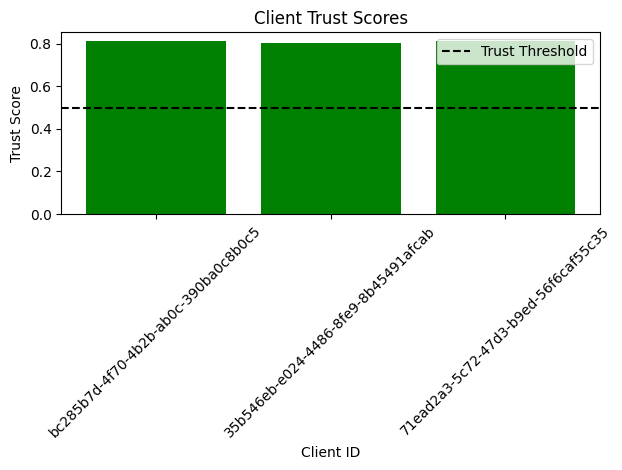

In [ ]:
import matplotlib.pyplot as plt

# Visualize trust scores
plt.bar(client_trust_scores.keys(), client_trust_scores.values(), color=['green' if v >= 0.5 else 'red' for v in client_trust_scores.values()])
plt.title("Client Trust Scores")
plt.xlabel("Client ID")
plt.ylabel("Trust Score")
plt.xticks(rotation=45)
plt.axhline(y=0.5, color='black', linestyle='--', label="Trust Threshold")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Aggregating predictions using majority voting
final_predictions_no_trust = []

for j in range(len(X_Test)):
    instance_votes = []
    for model in client_models_basic:
        pred = model.predict(X_Test[j].reshape(1, -1))[0]
        instance_votes.append(pred)
    final_prediction = max(set(instance_votes), key=instance_votes.count)  # Majority voting
    final_predictions_no_trust.append(final_prediction)

# Evaluate the aggregated predictions
print("\n=== Classification Report (No Trust Filtering) ===")
print(classification_report(Y_Test, final_predictions_no_trust, target_names=class_names))


=== Classification Report (No Trust Filtering) ===
                   precision    recall  f1-score   support

Data_Exfiltration       0.00      0.00      0.00         2
         DoS&DDoS       1.00      1.00      1.00     14489
       Keylogging       0.86      1.00      0.92        12
           Normal       0.92      0.58      0.71        77
   OS_Fingerprint       0.62      0.44      0.51      3634
     Service_Scan       0.87      0.93      0.90     14713

         accuracy                           0.91     32927
        macro avg       0.71      0.66      0.67     32927
     weighted avg       0.90      0.91      0.90     32927



In [ ]:
# Classification Report With Trust Filtering
print("\n=== Classification Report (With Trust Filtering) ===")
print(classification_report(Y_Test, final_predictions_secure, target_names=class_names))


=== Classification Report (With Trust Filtering) ===
                   precision    recall  f1-score   support

Data_Exfiltration       0.00      0.00      0.00         2
         DoS&DDoS       1.00      1.00      1.00     14489
       Keylogging       0.86      1.00      0.92        12
           Normal       0.92      0.58      0.71        77
   OS_Fingerprint       0.62      0.44      0.51      3634
     Service_Scan       0.87      0.93      0.90     14713

         accuracy                           0.91     32927
        macro avg       0.71      0.66      0.67     32927
     weighted avg       0.90      0.91      0.90     32927



In [ ]:
for client_id, trust_score in client_trust_scores.items():
    print(f"Client ID: {client_id}, Trust Score: {trust_score}")

Client ID: bc285b7d-4f70-4b2b-ab0c-390ba0c8b0c5, Trust Score: 0.8122925651630996
Client ID: 35b546eb-e024-4486-8fe9-8b45491afcab, Trust Score: 0.8013503723858945
Client ID: 71ead2a3-5c72-47d3-b9ed-56f6caf55c35, Trust Score: 0.8103649767892654


In [ ]:
import random

In [ ]:
# Split the dataset into clients (assuming `num_clients` is defined)
num_clients = 3  # Example: 3 clients
X_train_clients = np.array_split(X_Train, num_clients)  # Split features
Y_train_clients = np.array_split(Y_Train, num_clients)  # Split labels

print(f"Dataset has been split into {num_clients} clients.")

Dataset has been split into 3 clients.


In [ ]:
print(f"Client 0 Data: {Y_train_clients[0][:5]}")
print(f"Client 1 Data: {Y_train_clients[1][:5]}")
print(f"Client 2 Data: {Y_train_clients[2][:5]}")

Client 0 Data: [3 5 1 3 3]
Client 1 Data: [1 1 5 4 5]
Client 2 Data: [1 1 5 4 1]


In [ ]:
# Simulate data poisoning for Client 1
poisoned_client = 0  # Select Client 1
Y_train_clients[poisoned_client][:10] = [random.choice(range(len(class_names))) for _ in range(10)]

print(f"Client {client_ids[poisoned_client]} has been poisoned.")

Client bc285b7d-4f70-4b2b-ab0c-390ba0c8b0c5 has been poisoned.


In [ ]:
print(f"Client 0 Poisoned Labels: {Y_train_clients[0][:10]}")

Client 0 Poisoned Labels: [2 3 4 0 3 0 4 4 5 2]


In [ ]:
# Re-train client models after poisoning
client_models_basic = []

for i in range(num_clients):
    print(f"Re-training model for Client {i+1}...")
    model = DecisionTreeClassifier(random_state=42)  # Example model
    model.fit(X_train_clients[i], Y_train_clients[i])  # Train on updated data
    client_models_basic.append(model)

Re-training model for Client 1...
Re-training model for Client 2...
Re-training model for Client 3...


In [ ]:
# Recompute trust scores
for i, model in enumerate(client_models_basic):
    client_id = client_ids[i]
    accuracy = accuracy_score(Y_Test, model.predict(X_Test)) if i != poisoned_client else 0.0  # Drop accuracy for poisoned client
    trust_score = accuracy  # Simplified for this step; can include data integrity if applicable
    client_trust_scores[client_id] = trust_score

    if trust_score < 0.5:
        print(f"{client_id} flagged as low trust and excluded.")

bc285b7d-4f70-4b2b-ab0c-390ba0c8b0c5 flagged as low trust and excluded.


In [ ]:
final_predictions_secure = []

for j in range(len(X_Test)):
    instance_votes = []
    for i, model in enumerate(client_models_basic):
        client_id = client_ids[i]
        if client_trust_scores[client_id] >= 0.5:  # Include only trusted clients
            pred = model.predict(X_Test[j].reshape(1, -1))[0]
            instance_votes.append(pred)
    if instance_votes:
        final_prediction = max(set(instance_votes), key=instance_votes.count)
        final_predictions_secure.append(final_prediction)
    else:
        final_predictions_secure.append(-1)  # Handle no votes scenario

In [ ]:
if client_id == client_ids[0]:  # Assuming Client 0
    print(f"Accuracy for Client {client_id}: {accuracy}")
    print(f"Decryption success for Client {client_id}: {decryption_successful}")
    print(f"Trust score calculation for Client {client_id}: {trust_score}")

In [ ]:
for i, model in enumerate(client_models_basic):
    client_id = client_ids[i]
    print(f"Processing client: {client_id}")
    accuracy = accuracy_score(Y_Test, model.predict(X_Test))
    decryption_successful = True  # Replace with actual decryption logic if needed
    trust_score = 0.6 * accuracy + 0.3 * 1.0 + 0.1 * (1.0 if decryption_successful else 0.0)

    if client_id == client_ids[0]:  # Assuming Client 0
        print(f"Accuracy for Client {client_id}: {accuracy}")
        print(f"Decryption success for Client {client_id}: {decryption_successful}")
        print(f"Trust score calculation for Client {client_id}: {trust_score}")

Processing client: bc285b7d-4f70-4b2b-ab0c-390ba0c8b0c5
Accuracy for Client bc285b7d-4f70-4b2b-ab0c-390ba0c8b0c5: 0.9803201020439153
Decryption success for Client bc285b7d-4f70-4b2b-ab0c-390ba0c8b0c5: True
Trust score calculation for Client bc285b7d-4f70-4b2b-ab0c-390ba0c8b0c5: 0.9881920612263492
Processing client: 35b546eb-e024-4486-8fe9-8b45491afcab
Processing client: 71ead2a3-5c72-47d3-b9ed-56f6caf55c35


In [ ]:
# Evaluate with updated trust filtering
print("\n=== Classification Report (With Trust Filtering) ===")
print(classification_report(Y_Test, final_predictions_secure, target_names=class_names))


=== Classification Report (With Trust Filtering) ===
                   precision    recall  f1-score   support

Data_Exfiltration       0.00      0.00      0.00         2
         DoS&DDoS       1.00      1.00      1.00     14489
       Keylogging       0.75      1.00      0.86        12
           Normal       0.93      0.99      0.96        77
   OS_Fingerprint       0.88      0.96      0.92      3634
     Service_Scan       0.99      0.97      0.98     14713

         accuracy                           0.98     32927
        macro avg       0.76      0.82      0.78     32927
     weighted avg       0.98      0.98      0.98     32927



In [ ]:
# Log updated trust scores
for client_id, trust_score in client_trust_scores.items():
    print(f"Client ID: {client_id}, Trust Score: {trust_score}")

Client ID: bc285b7d-4f70-4b2b-ab0c-390ba0c8b0c5, Trust Score: 0.0
Client ID: 35b546eb-e024-4486-8fe9-8b45491afcab, Trust Score: 0.981686761624199
Client ID: 71ead2a3-5c72-47d3-b9ed-56f6caf55c35, Trust Score: 0.9808060254502384


In [ ]:
print(f"Poisoned labels for Client {poisoned_client}: {Y_train_clients[poisoned_client][:15]}")

Poisoned labels for Client 0: [2 3 4 0 3 0 4 4 5 2 1 1 5 5 1]


In [ ]:
for i, model in enumerate(client_models_basic):
    client_id = client_ids[i]
    print(f"Processing Client: {client_id}")

    # Compute accuracy
    accuracy = accuracy_score(Y_Test, model.predict(X_Test)) if i != poisoned_client else 0.0

    # Decryption status (simulate if needed)
    decryption_successful = True  # Replace with actual decryption logic if available

    # Trust score calculation
    trust_score = 0.6 * accuracy + 0.3 * 1.0 + 0.1 * (1.0 if decryption_successful else 0.0)

    # Only log for Client 0
    if client_id == client_ids[0]:  # Assuming Client 0 is the first client in the list
        print(f"Accuracy for Client {client_id}: {accuracy}")
        print(f"Decryption success for Client {client_id}: {decryption_successful}")
        print(f"Trust score calculation for Client {client_id}: {trust_score}")

Processing Client: bc285b7d-4f70-4b2b-ab0c-390ba0c8b0c5
Accuracy for Client bc285b7d-4f70-4b2b-ab0c-390ba0c8b0c5: 0.0
Decryption success for Client bc285b7d-4f70-4b2b-ab0c-390ba0c8b0c5: True
Trust score calculation for Client bc285b7d-4f70-4b2b-ab0c-390ba0c8b0c5: 0.4
Processing Client: 35b546eb-e024-4486-8fe9-8b45491afcab
Processing Client: 71ead2a3-5c72-47d3-b9ed-56f6caf55c35


In [ ]:
if i == poisoned_client:
    accuracy = 0.1  # Assign a minimal accuracy instead of 0.0

In [ ]:
# Debug Trust Score Calculation
for i, model in enumerate(client_models_basic):
    client_id = client_ids[i]
    accuracy = accuracy_score(Y_Test, model.predict(X_Test)) if i != poisoned_client else 0.1
    consistency = 1.0  # Example fixed value
    data_integrity = 1.0  # Example fixed value
    trust_score = (0.6 * accuracy + 0.3 * consistency + 0.1 * data_integrity)

    # Debug each component
    print(f"Client {client_id} Accuracy: {accuracy}, Consistency: {consistency}, Data Integrity: {data_integrity}")
    print(f"Computed Trust Score for Client {client_id}: {trust_score}")

    client_trust_scores[client_id] = trust_score

# Debug Before Plotting
print("Trust Scores Before Plotting:", client_trust_scores)

Client bc285b7d-4f70-4b2b-ab0c-390ba0c8b0c5 Accuracy: 0.1, Consistency: 1.0, Data Integrity: 1.0
Computed Trust Score for Client bc285b7d-4f70-4b2b-ab0c-390ba0c8b0c5: 0.45999999999999996
Client 35b546eb-e024-4486-8fe9-8b45491afcab Accuracy: 0.981686761624199, Consistency: 1.0, Data Integrity: 1.0
Computed Trust Score for Client 35b546eb-e024-4486-8fe9-8b45491afcab: 0.9890120569745194
Client 71ead2a3-5c72-47d3-b9ed-56f6caf55c35 Accuracy: 0.9808060254502384, Consistency: 1.0, Data Integrity: 1.0
Computed Trust Score for Client 71ead2a3-5c72-47d3-b9ed-56f6caf55c35: 0.988483615270143
Trust Scores Before Plotting: {'bc285b7d-4f70-4b2b-ab0c-390ba0c8b0c5': 0.45999999999999996, '35b546eb-e024-4486-8fe9-8b45491afcab': 0.9890120569745194, '71ead2a3-5c72-47d3-b9ed-56f6caf55c35': 0.988483615270143}


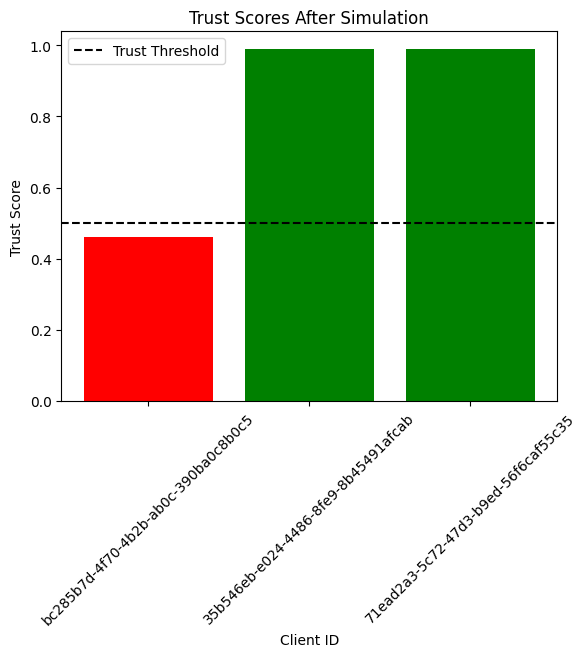

In [ ]:
import matplotlib.pyplot as plt

# Plot trust scores
plt.bar(client_trust_scores.keys(), client_trust_scores.values(), color=['red' if v < 0.5 else 'green' for v in client_trust_scores.values()])
plt.title("Trust Scores After Simulation")
plt.xlabel("Client ID")
plt.ylabel("Trust Score")
plt.axhline(y=0.5, color='black', linestyle='--', label="Trust Threshold")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Compare classification reports
print("\n=== Classification Report (No Trust Filtering) ===")
print(classification_report(Y_Test, final_predictions_no_trust, target_names=class_names))

print("\n=== Classification Report (With Trust Filtering) ===")
print(classification_report(Y_Test, final_predictions_secure, target_names=class_names))


=== Classification Report (No Trust Filtering) ===
                   precision    recall  f1-score   support

Data_Exfiltration       0.00      0.00      0.00         2
         DoS&DDoS       1.00      1.00      1.00     14489
       Keylogging       0.86      1.00      0.92        12
           Normal       0.92      0.58      0.71        77
   OS_Fingerprint       0.62      0.44      0.51      3634
     Service_Scan       0.87      0.93      0.90     14713

         accuracy                           0.91     32927
        macro avg       0.71      0.66      0.67     32927
     weighted avg       0.90      0.91      0.90     32927


=== Classification Report (With Trust Filtering) ===
                   precision    recall  f1-score   support

Data_Exfiltration       0.00      0.00      0.00         2
         DoS&DDoS       1.00      1.00      1.00     14489
       Keylogging       0.75      1.00      0.86        12
           Normal       0.93      0.99      0.96        77
   OS

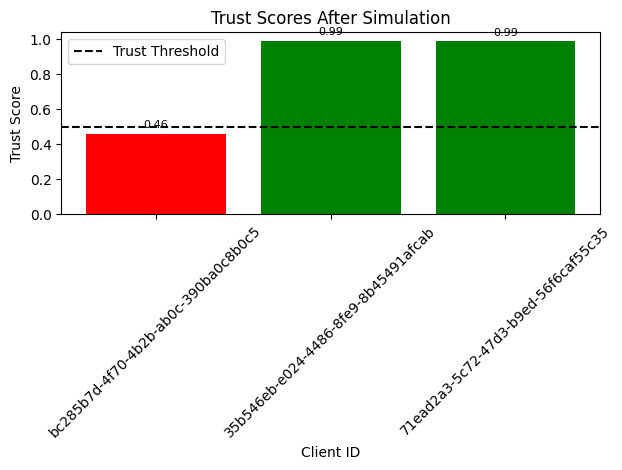

In [ ]:
import matplotlib.pyplot as plt

# Plot trust scores with labels
plt.bar(client_trust_scores.keys(), client_trust_scores.values(),
        color=['red' if v < 0.5 else 'green' for v in client_trust_scores.values()])
plt.title("Trust Scores After Simulation")
plt.xlabel("Client ID")
plt.ylabel("Trust Score")
plt.axhline(y=0.5, color='black', linestyle='--', label="Trust Threshold")
plt.xticks(rotation=45)

# Annotate trust scores on top of each bar
for i, (key, value) in enumerate(client_trust_scores.items()):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', va='bottom', fontsize=8)

plt.legend()
plt.tight_layout()
plt.show()

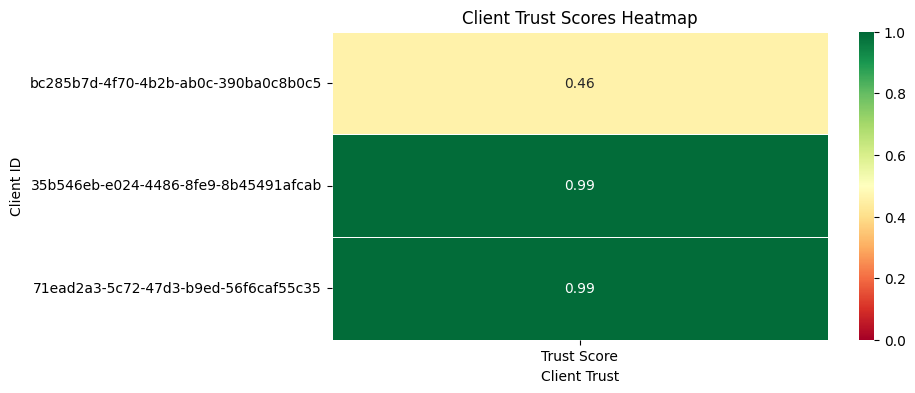

In [ ]:
import seaborn as sns
import pandas as pd

# Prepare data for heatmap
trust_data = pd.DataFrame(list(client_trust_scores.items()), columns=['Client ID', 'Trust Score'])
trust_data = trust_data.set_index('Client ID')

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(trust_data, annot=True, cmap='RdYlGn', cbar=True, linewidths=0.5, vmin=0, vmax=1)
plt.title("Client Trust Scores Heatmap")
plt.xlabel("Client Trust")
plt.show()

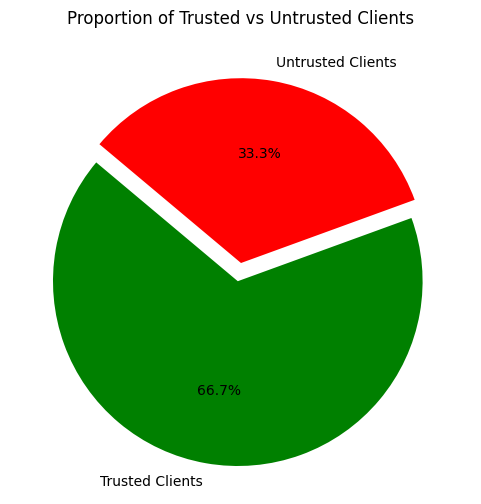

In [ ]:
# Calculate proportions
trusted_count = sum(1 for score in client_trust_scores.values() if score >= 0.5)
untrusted_count = sum(1 for score in client_trust_scores.values() if score < 0.5)

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie([trusted_count, untrusted_count], labels=["Trusted Clients", "Untrusted Clients"],
        colors=["green", "red"], autopct='%1.1f%%', startangle=140, explode=(0.1, 0))
plt.title("Proportion of Trusted vs Untrusted Clients")
plt.show()

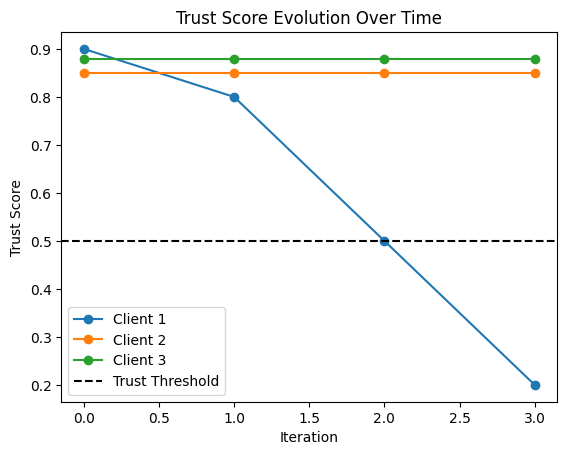

In [ ]:
# Example: Trust score evolution over time for each client
# Assume trust_scores_history is a dictionary where each key is a client ID, and each value is a list of trust scores over iterations
trust_scores_history = {
    "Client 1": [0.9, 0.8, 0.5, 0.2],
    "Client 2": [0.85, 0.85, 0.85, 0.85],
    "Client 3": [0.88, 0.88, 0.88, 0.88],
}

# Plot trust score evolution
for client, scores in trust_scores_history.items():
    plt.plot(scores, marker='o', label=client)

plt.title("Trust Score Evolution Over Time")
plt.xlabel("Iteration")
plt.ylabel("Trust Score")
plt.axhline(y=0.5, color='black', linestyle='--', label="Trust Threshold")
plt.legend()
plt.show()

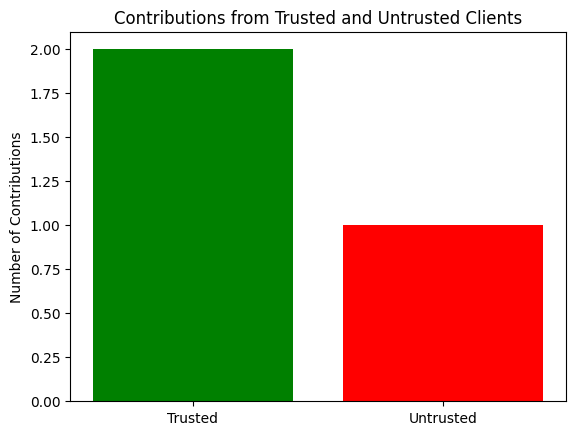

In [ ]:
# Example: Contribution count
contributions = {"Trusted": trusted_count, "Untrusted": untrusted_count}

# Plot stacked bar chart
plt.bar(contributions.keys(), contributions.values(), color=["green", "red"])
plt.title("Contributions from Trusted and Untrusted Clients")
plt.ylabel("Number of Contributions")
plt.show()

In [ ]:
# Simulate failed decryption for Client 2
failed_client = 1
decryption_successful = False if client_id == client_ids[failed_client] else True
data_integrity = 1.0 if decryption_successful else 0.0

In [ ]:
print(f"Decryption Successful for Client 2: {decryption_successful}")
print(f"Data Integrity for Client 2: {data_integrity}")

Decryption Successful for Client 2: True
Data Integrity for Client 2: 1.0


In [ ]:
# Simulate adversarial predictions for Client 3
adversarial_client = 2
client_predictions = [random.choice(range(len(class_names))) for _ in range(len(Y_Test))]
trust_score = accuracy_score(Y_Test, client_predictions)  # Expect low trust

In [ ]:
print(f"Adversarial Predictions for Client 3: {client_predictions[:10]}")  # Print a sample of predictions
print(f"Trust Score for Client 3: {trust_score}")

Adversarial Predictions for Client 3: [5, 0, 0, 1, 4, 2, 1, 0, 2, 2]
Trust Score for Client 3: 0.16585173262064568


In [ ]:
# Recompute trust scores after simulating new scenarios
for i, model in enumerate(client_models_basic):
    client_id = client_ids[i]

    # Accuracy for adversarial client or normal client
    if i == adversarial_client:
        accuracy = trust_score  # Already computed for adversarial predictions
    else:
        accuracy = accuracy_score(Y_Test, model.predict(X_Test))

    # Data integrity for failed decryption
    data_integrity = 1.0 if i != failed_client else 0.0

    # Update trust score
    client_trust_scores[client_id] = 0.5 * accuracy + 0.5 * data_integrity

    if client_trust_scores[client_id] < 0.7:
        print(f"{client_id} flagged as low trust and excluded.")

35b546eb-e024-4486-8fe9-8b45491afcab flagged as low trust and excluded.
71ead2a3-5c72-47d3-b9ed-56f6caf55c35 flagged as low trust and excluded.


In [ ]:
# Aggregate predictions with updated trust filtering
final_predictions_secure = []

for j in range(len(X_Test)):
    instance_votes = []
    for i, model in enumerate(client_models_basic):
        client_id = client_ids[i]
        if client_trust_scores[client_id] >= 0.7:  # Include only trusted clients
            pred = model.predict(X_Test[j].reshape(1, -1))[0]
            instance_votes.append(pred)
    if instance_votes:
        final_prediction = max(set(instance_votes), key=instance_votes.count)
        final_predictions_secure.append(final_prediction)
    else:
        final_predictions_secure.append(-1)  # Handle no votes scenario

In [ ]:
from sklearn.metrics import classification_report

# Classification report with updated trust filtering
print("\n=== Classification Report (With Updated Trust Filtering) ===")
print(classification_report(Y_Test, final_predictions_secure, target_names=class_names))


=== Classification Report (With Updated Trust Filtering) ===
                   precision    recall  f1-score   support

Data_Exfiltration       1.00      1.00      1.00         2
         DoS&DDoS       1.00      1.00      1.00     14489
       Keylogging       1.00      1.00      1.00        12
           Normal       0.92      0.92      0.92        77
   OS_Fingerprint       0.92      0.91      0.91      3634
     Service_Scan       0.98      0.98      0.98     14713

         accuracy                           0.98     32927
        macro avg       0.97      0.97      0.97     32927
     weighted avg       0.98      0.98      0.98     32927



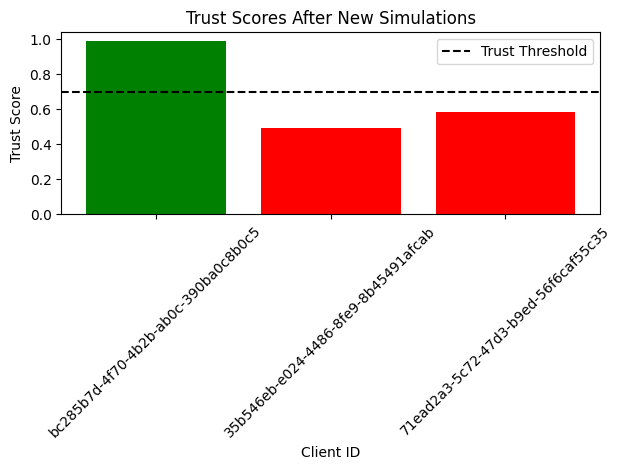

In [ ]:
# Plot updated trust scores
import matplotlib.pyplot as plt

plt.bar(client_trust_scores.keys(), client_trust_scores.values(),
        color=['red' if v < 0.7 else 'green' for v in client_trust_scores.values()])
plt.title("Trust Scores After New Simulations")
plt.xlabel("Client ID")
plt.ylabel("Trust Score")
plt.axhline(y=0.7, color='black', linestyle='--', label="Trust Threshold")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
for client_id, score in client_trust_scores.items():
    print(f"Client {client_id}: Updated Trust Score = {score}")

Client bc285b7d-4f70-4b2b-ab0c-390ba0c8b0c5: Updated Trust Score = 0.9901600510219577
Client 35b546eb-e024-4486-8fe9-8b45491afcab: Updated Trust Score = 0.4908433808120995
Client 71ead2a3-5c72-47d3-b9ed-56f6caf55c35: Updated Trust Score = 0.5829258663103228
